<a href="https://colab.research.google.com/github/Jahnavi-Krishna/Deep-Learning/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt

In [ ]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Number of GPUs:', torch.cuda.device_count())

Device: cuda
Number of GPUs: 1


In [ ]:

# -----------------------------------------------------------------------------
# Data Augmentations
# -----------------------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping
    transforms.Pad(4),                      # Zero-padding to 40x40
    transforms.RandomCrop(32),              # Randomly crop back to 32x32
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    # Minimal addition: Random Erasing
    transforms.RandomErasing(p=0.2),  # You can tune p=0.1~0.3
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='Dataset', train=True,
                                        download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='Dataset', train=False,
                                       download=True, transform=val_transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5654321].


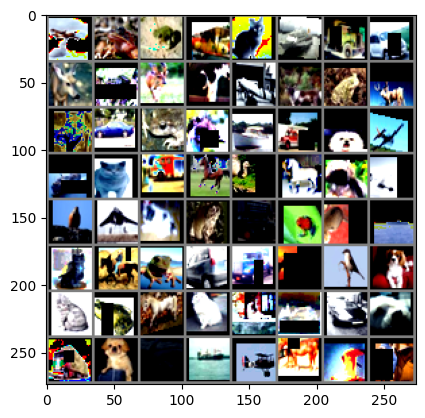

plane frog  frog  plane cat   ship  truck car   deer  frog  deer  cat   plane deer  frog  deer  cat   car   frog  bird  ship  truck dog   plane ship  cat   truck horse bird  horse dog   plane bird  plane dog   frog  truck frog  cat   ship  cat   horse frog  car   truck deer  bird  dog   cat   frog  horse cat   cat   car   car   dog   truck dog   bird  ship  plane horse bird  horse


In [ ]:
combined_trainset = torch.utils.data.ConcatDataset([trainset, valset])
combined_train_loader = torch.utils.data.DataLoader(
    combined_trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    # Just a helper to visualize
    img = img / 2 + 0.5  # unnormalize if you used (0.5,0.5,0.5)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv1x1(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn4 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out = self.bn4(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        return out

class PyramidNet(nn.Module):
    def __init__(self, config):
        super(PyramidNet, self).__init__()

        input_shape = config['input_shape']
        n_classes = config['n_classes']
        depth = config['depth']
        alpha = config['alpha']

        block = Bottleneck
        self.inplanes = 16
        n = (depth - 2) // 9  # Bottleneck formula (depth-2)/9

        # Calculate how much we widen each stage
        self.start_channel = 16
        self.addrate = alpha / (3 * n)

        # Initial convolution
        self.conv1 = nn.Conv2d(input_shape[1], 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Build the 3 layers
        current_channel = self.start_channel
        self.layer1 = self._make_layer(block, current_channel, n, stride=1)
        current_channel += self.addrate * n
        self.layer2 = self._make_layer(block, current_channel, n, stride=2)
        current_channel += self.addrate * n
        self.layer3 = self._make_layer(block, current_channel, n, stride=2)

        # Final heads
        self.bn_final = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.inplanes, n_classes)

        # Initialize
        self.apply(initialize_weights)

    def _make_layer(self, block, start_planes, blocks, stride=1):
        downsample = None
        end_planes = start_planes + self.addrate * (blocks - 1)
        planes = int(round(start_planes))

        # Downsample if shape is changing or stride = 2
        if stride != 1 or self.inplanes != planes * block.expansion:
            if stride == 2:
                downsample = nn.Sequential(
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=1, padding=0, bias=False)
                    if self.inplanes != planes * block.expansion else nn.Identity()
                )
            else:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                             kernel_size=1, stride=stride, padding=0, bias=False)
                    if self.inplanes != planes * block.expansion else nn.Identity()
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion

        # Remaining blocks in this layer
        for i in range(1, blocks):
            current_planes = start_planes + self.addrate * i
            planes = int(round(current_planes))

            downsample = None
            if self.inplanes != planes * block.expansion:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=1, padding=0, bias=False)
                )

            layers.append(block(self.inplanes, planes, 1, downsample))
            self.inplanes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn_final(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
from collections import OrderedDict

model_config = OrderedDict([
    ('arch', 'pyramid_net'),
    ('depth', 26),  # from original code
    ('base_channels', 16),
    ('alpha', 300),
    ('input_shape', (1, 3, 32, 32)),
    ('n_classes', 10),
])

model = PyramidNet(model_config).to(device)

def val(net):
    import numpy as np
    total_params = 0
    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.cpu().data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))

val(model)

Total number of params 4574414
Total layers 26


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

num_epochs = 200
learning_rate = 0.1

# Minimal addition: Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=0.0001)

# Decays LR at epoch 150 and 225 by gamma=0.1
scheduler = MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)

train_losses = []
val_losses = []

def train(epoch):
    model.train()
    running_loss = 0.0
    total_step = len(train_loader)

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward & update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

    # Average epoch loss
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Step the scheduler each epoch
    scheduler.step()

In [ ]:
def validate(epoch):
    model.eval()
    running_loss_val = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            tloss = criterion(outputs, labels)
            running_loss_val += tloss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss_val / len(val_loader)
    val_losses.append(epoch_loss)

    accuracy = 100.0 * correct / total
    print(f'Validation Epoch [{epoch+1}/{num_epochs}] '
          f'- Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Step [100/782], Loss: 2.3316
Epoch [1/200], Step [200/782], Loss: 2.0212
Epoch [1/200], Step [300/782], Loss: 2.0493
Epoch [1/200], Step [400/782], Loss: 2.0182
Epoch [1/200], Step [500/782], Loss: 2.0619
Epoch [1/200], Step [600/782], Loss: 1.8789
Epoch [1/200], Step [700/782], Loss: 2.0688


  0%|          | 1/200 [00:26<1:28:00, 26.54s/it]

Validation Epoch [1/200] - Loss: 1.7489, Accuracy: 41.45%
Epoch [2/200], Step [100/782], Loss: 1.8089
Epoch [2/200], Step [200/782], Loss: 2.0178
Epoch [2/200], Step [300/782], Loss: 1.7885
Epoch [2/200], Step [400/782], Loss: 1.7483
Epoch [2/200], Step [500/782], Loss: 1.7516
Epoch [2/200], Step [600/782], Loss: 1.7648
Epoch [2/200], Step [700/782], Loss: 1.6535


  1%|          | 2/200 [00:50<1:22:48, 25.09s/it]

Validation Epoch [2/200] - Loss: 1.5418, Accuracy: 53.47%
Epoch [3/200], Step [100/782], Loss: 1.5358
Epoch [3/200], Step [200/782], Loss: 1.4379
Epoch [3/200], Step [300/782], Loss: 1.5943
Epoch [3/200], Step [400/782], Loss: 1.5932
Epoch [3/200], Step [500/782], Loss: 1.7315
Epoch [3/200], Step [600/782], Loss: 1.5643
Epoch [3/200], Step [700/782], Loss: 1.5970


  2%|▏         | 3/200 [01:15<1:21:29, 24.82s/it]

Validation Epoch [3/200] - Loss: 1.5065, Accuracy: 57.19%
Epoch [4/200], Step [100/782], Loss: 1.4315
Epoch [4/200], Step [200/782], Loss: 1.5132
Epoch [4/200], Step [300/782], Loss: 1.4506
Epoch [4/200], Step [400/782], Loss: 1.5262
Epoch [4/200], Step [500/782], Loss: 1.4876
Epoch [4/200], Step [600/782], Loss: 1.5621
Epoch [4/200], Step [700/782], Loss: 1.6230


  2%|▏         | 4/200 [01:39<1:20:04, 24.51s/it]

Validation Epoch [4/200] - Loss: 1.4067, Accuracy: 61.93%
Epoch [5/200], Step [100/782], Loss: 1.3009
Epoch [5/200], Step [200/782], Loss: 1.3836
Epoch [5/200], Step [300/782], Loss: 1.4712
Epoch [5/200], Step [400/782], Loss: 1.5474
Epoch [5/200], Step [500/782], Loss: 1.2869
Epoch [5/200], Step [600/782], Loss: 1.2946
Epoch [5/200], Step [700/782], Loss: 1.3775


  2%|▎         | 5/200 [02:03<1:19:40, 24.51s/it]

Validation Epoch [5/200] - Loss: 1.2500, Accuracy: 69.12%
Epoch [6/200], Step [100/782], Loss: 1.1562
Epoch [6/200], Step [200/782], Loss: 1.4427
Epoch [6/200], Step [300/782], Loss: 1.3588
Epoch [6/200], Step [400/782], Loss: 1.2192
Epoch [6/200], Step [500/782], Loss: 1.3580
Epoch [6/200], Step [600/782], Loss: 1.3376
Epoch [6/200], Step [700/782], Loss: 1.4547


  3%|▎         | 6/200 [02:28<1:19:16, 24.52s/it]

Validation Epoch [6/200] - Loss: 1.3593, Accuracy: 64.48%
Epoch [7/200], Step [100/782], Loss: 1.3500
Epoch [7/200], Step [200/782], Loss: 1.3424
Epoch [7/200], Step [300/782], Loss: 1.1522
Epoch [7/200], Step [400/782], Loss: 1.3795
Epoch [7/200], Step [500/782], Loss: 1.1960
Epoch [7/200], Step [600/782], Loss: 1.3142
Epoch [7/200], Step [700/782], Loss: 1.1026


  4%|▎         | 7/200 [02:52<1:18:50, 24.51s/it]

Validation Epoch [7/200] - Loss: 1.2511, Accuracy: 68.51%
Epoch [8/200], Step [100/782], Loss: 1.4390
Epoch [8/200], Step [200/782], Loss: 1.3153
Epoch [8/200], Step [300/782], Loss: 1.2900
Epoch [8/200], Step [400/782], Loss: 1.1976
Epoch [8/200], Step [500/782], Loss: 1.1408
Epoch [8/200], Step [600/782], Loss: 1.3607
Epoch [8/200], Step [700/782], Loss: 1.1318


  4%|▍         | 8/200 [03:17<1:18:44, 24.61s/it]

Validation Epoch [8/200] - Loss: 1.2171, Accuracy: 72.06%
Epoch [9/200], Step [100/782], Loss: 1.2313
Epoch [9/200], Step [200/782], Loss: 1.2107
Epoch [9/200], Step [300/782], Loss: 1.1340
Epoch [9/200], Step [400/782], Loss: 1.2290
Epoch [9/200], Step [500/782], Loss: 1.2859
Epoch [9/200], Step [600/782], Loss: 1.1489
Epoch [9/200], Step [700/782], Loss: 1.0705


  4%|▍         | 9/200 [03:43<1:19:24, 24.95s/it]

Validation Epoch [9/200] - Loss: 1.0765, Accuracy: 76.69%
Epoch [10/200], Step [100/782], Loss: 1.2203
Epoch [10/200], Step [200/782], Loss: 1.0941
Epoch [10/200], Step [300/782], Loss: 1.2481
Epoch [10/200], Step [400/782], Loss: 1.1924
Epoch [10/200], Step [500/782], Loss: 1.2377
Epoch [10/200], Step [600/782], Loss: 1.3434
Epoch [10/200], Step [700/782], Loss: 1.3074


  5%|▌         | 10/200 [04:07<1:18:42, 24.86s/it]

Validation Epoch [10/200] - Loss: 1.1174, Accuracy: 74.33%
Epoch [11/200], Step [100/782], Loss: 1.1581
Epoch [11/200], Step [200/782], Loss: 1.2143
Epoch [11/200], Step [300/782], Loss: 1.3785
Epoch [11/200], Step [400/782], Loss: 1.1876
Epoch [11/200], Step [500/782], Loss: 1.0584
Epoch [11/200], Step [600/782], Loss: 1.3077
Epoch [11/200], Step [700/782], Loss: 1.1572


  6%|▌         | 11/200 [04:33<1:18:43, 24.99s/it]

Validation Epoch [11/200] - Loss: 1.1164, Accuracy: 75.62%
Epoch [12/200], Step [100/782], Loss: 1.1535
Epoch [12/200], Step [200/782], Loss: 1.1604
Epoch [12/200], Step [300/782], Loss: 1.2240
Epoch [12/200], Step [400/782], Loss: 1.2775
Epoch [12/200], Step [500/782], Loss: 1.1825
Epoch [12/200], Step [600/782], Loss: 1.2722
Epoch [12/200], Step [700/782], Loss: 1.1873


  6%|▌         | 12/200 [04:57<1:17:32, 24.75s/it]

Validation Epoch [12/200] - Loss: 1.0845, Accuracy: 76.72%
Epoch [13/200], Step [100/782], Loss: 1.1831
Epoch [13/200], Step [200/782], Loss: 1.1726
Epoch [13/200], Step [300/782], Loss: 1.1571
Epoch [13/200], Step [400/782], Loss: 1.0426
Epoch [13/200], Step [500/782], Loss: 1.0801
Epoch [13/200], Step [600/782], Loss: 1.1012
Epoch [13/200], Step [700/782], Loss: 0.9463


  6%|▋         | 13/200 [05:21<1:16:46, 24.63s/it]

Validation Epoch [13/200] - Loss: 1.0288, Accuracy: 79.43%
Epoch [14/200], Step [100/782], Loss: 1.0038
Epoch [14/200], Step [200/782], Loss: 1.1005
Epoch [14/200], Step [300/782], Loss: 0.9951
Epoch [14/200], Step [400/782], Loss: 0.8947
Epoch [14/200], Step [500/782], Loss: 1.0600
Epoch [14/200], Step [600/782], Loss: 1.1784
Epoch [14/200], Step [700/782], Loss: 1.0503


  7%|▋         | 14/200 [05:45<1:15:50, 24.46s/it]

Validation Epoch [14/200] - Loss: 1.1701, Accuracy: 71.78%
Epoch [15/200], Step [100/782], Loss: 1.3796
Epoch [15/200], Step [200/782], Loss: 1.0220
Epoch [15/200], Step [300/782], Loss: 1.0174
Epoch [15/200], Step [400/782], Loss: 1.1516
Epoch [15/200], Step [500/782], Loss: 1.0061
Epoch [15/200], Step [600/782], Loss: 1.1147
Epoch [15/200], Step [700/782], Loss: 1.1608


  8%|▊         | 15/200 [06:10<1:15:12, 24.39s/it]

Validation Epoch [15/200] - Loss: 0.9893, Accuracy: 82.27%
Epoch [16/200], Step [100/782], Loss: 1.2374
Epoch [16/200], Step [200/782], Loss: 1.3329
Epoch [16/200], Step [300/782], Loss: 0.9937
Epoch [16/200], Step [400/782], Loss: 1.0037
Epoch [16/200], Step [500/782], Loss: 1.1205
Epoch [16/200], Step [600/782], Loss: 1.0630
Epoch [16/200], Step [700/782], Loss: 1.1799


  8%|▊         | 16/200 [06:33<1:14:20, 24.24s/it]

Validation Epoch [16/200] - Loss: 1.0569, Accuracy: 79.05%
Epoch [17/200], Step [100/782], Loss: 1.0020
Epoch [17/200], Step [200/782], Loss: 1.3415
Epoch [17/200], Step [300/782], Loss: 1.1265
Epoch [17/200], Step [400/782], Loss: 1.1780
Epoch [17/200], Step [500/782], Loss: 1.0956
Epoch [17/200], Step [600/782], Loss: 1.1618
Epoch [17/200], Step [700/782], Loss: 1.1557


  8%|▊         | 17/200 [06:57<1:13:46, 24.19s/it]

Validation Epoch [17/200] - Loss: 1.0275, Accuracy: 80.13%
Epoch [18/200], Step [100/782], Loss: 1.1248
Epoch [18/200], Step [200/782], Loss: 1.1496
Epoch [18/200], Step [300/782], Loss: 1.1102
Epoch [18/200], Step [400/782], Loss: 1.2658
Epoch [18/200], Step [500/782], Loss: 1.0037
Epoch [18/200], Step [600/782], Loss: 1.1815
Epoch [18/200], Step [700/782], Loss: 1.1090


  9%|▉         | 18/200 [07:22<1:13:16, 24.16s/it]

Validation Epoch [18/200] - Loss: 1.0482, Accuracy: 78.60%
Epoch [19/200], Step [100/782], Loss: 1.2662
Epoch [19/200], Step [200/782], Loss: 1.0461
Epoch [19/200], Step [300/782], Loss: 1.0331
Epoch [19/200], Step [400/782], Loss: 1.2245
Epoch [19/200], Step [500/782], Loss: 0.9794
Epoch [19/200], Step [600/782], Loss: 0.9664
Epoch [19/200], Step [700/782], Loss: 1.1059


 10%|▉         | 19/200 [07:45<1:12:36, 24.07s/it]

Validation Epoch [19/200] - Loss: 0.9961, Accuracy: 81.08%
Epoch [20/200], Step [100/782], Loss: 1.2582
Epoch [20/200], Step [200/782], Loss: 1.0920
Epoch [20/200], Step [300/782], Loss: 1.0523
Epoch [20/200], Step [400/782], Loss: 1.0849
Epoch [20/200], Step [500/782], Loss: 1.2761
Epoch [20/200], Step [600/782], Loss: 1.0939
Epoch [20/200], Step [700/782], Loss: 1.1765


 10%|█         | 20/200 [08:10<1:12:29, 24.16s/it]

Validation Epoch [20/200] - Loss: 0.9675, Accuracy: 82.07%
Epoch [21/200], Step [100/782], Loss: 1.0316
Epoch [21/200], Step [200/782], Loss: 0.9147
Epoch [21/200], Step [300/782], Loss: 1.0393
Epoch [21/200], Step [400/782], Loss: 1.0652
Epoch [21/200], Step [500/782], Loss: 1.1136
Epoch [21/200], Step [600/782], Loss: 1.1407
Epoch [21/200], Step [700/782], Loss: 1.0565


 10%|█         | 21/200 [08:36<1:14:16, 24.89s/it]

Validation Epoch [21/200] - Loss: 0.9907, Accuracy: 81.49%
Epoch [22/200], Step [100/782], Loss: 1.0181
Epoch [22/200], Step [200/782], Loss: 1.0341
Epoch [22/200], Step [300/782], Loss: 1.0886
Epoch [22/200], Step [400/782], Loss: 1.0332
Epoch [22/200], Step [500/782], Loss: 1.1337
Epoch [22/200], Step [600/782], Loss: 1.0896
Epoch [22/200], Step [700/782], Loss: 1.2299


 11%|█         | 22/200 [09:01<1:13:09, 24.66s/it]

Validation Epoch [22/200] - Loss: 1.1668, Accuracy: 76.73%
Epoch [23/200], Step [100/782], Loss: 1.0791
Epoch [23/200], Step [200/782], Loss: 1.0795
Epoch [23/200], Step [300/782], Loss: 1.1607
Epoch [23/200], Step [400/782], Loss: 1.0477
Epoch [23/200], Step [500/782], Loss: 0.9937
Epoch [23/200], Step [600/782], Loss: 0.9759
Epoch [23/200], Step [700/782], Loss: 1.0583


 12%|█▏        | 23/200 [09:25<1:12:12, 24.47s/it]

Validation Epoch [23/200] - Loss: 1.0475, Accuracy: 79.26%
Epoch [24/200], Step [100/782], Loss: 0.9424
Epoch [24/200], Step [200/782], Loss: 1.1509
Epoch [24/200], Step [300/782], Loss: 1.1106
Epoch [24/200], Step [400/782], Loss: 1.0153
Epoch [24/200], Step [500/782], Loss: 1.1180
Epoch [24/200], Step [600/782], Loss: 1.0660
Epoch [24/200], Step [700/782], Loss: 1.0289


 12%|█▏        | 24/200 [09:49<1:11:22, 24.33s/it]

Validation Epoch [24/200] - Loss: 1.0375, Accuracy: 80.25%
Epoch [25/200], Step [100/782], Loss: 1.2105
Epoch [25/200], Step [200/782], Loss: 1.0720
Epoch [25/200], Step [300/782], Loss: 1.1710
Epoch [25/200], Step [400/782], Loss: 1.0221
Epoch [25/200], Step [500/782], Loss: 1.1363
Epoch [25/200], Step [600/782], Loss: 1.1515
Epoch [25/200], Step [700/782], Loss: 1.0884


 12%|█▎        | 25/200 [10:13<1:10:48, 24.28s/it]

Validation Epoch [25/200] - Loss: 0.9769, Accuracy: 82.45%
Epoch [26/200], Step [100/782], Loss: 1.1646
Epoch [26/200], Step [200/782], Loss: 1.0392
Epoch [26/200], Step [300/782], Loss: 0.9461
Epoch [26/200], Step [400/782], Loss: 1.2193
Epoch [26/200], Step [500/782], Loss: 0.9725
Epoch [26/200], Step [600/782], Loss: 1.0447
Epoch [26/200], Step [700/782], Loss: 1.2372


 13%|█▎        | 26/200 [10:37<1:10:16, 24.23s/it]

Validation Epoch [26/200] - Loss: 0.9691, Accuracy: 82.81%
Epoch [27/200], Step [100/782], Loss: 1.0596
Epoch [27/200], Step [200/782], Loss: 0.8787
Epoch [27/200], Step [300/782], Loss: 1.0778
Epoch [27/200], Step [400/782], Loss: 0.9118
Epoch [27/200], Step [500/782], Loss: 0.9073
Epoch [27/200], Step [600/782], Loss: 1.2799
Epoch [27/200], Step [700/782], Loss: 1.0740


 14%|█▎        | 27/200 [11:01<1:09:53, 24.24s/it]

Validation Epoch [27/200] - Loss: 0.9688, Accuracy: 82.49%
Epoch [28/200], Step [100/782], Loss: 1.0337
Epoch [28/200], Step [200/782], Loss: 0.9495
Epoch [28/200], Step [300/782], Loss: 1.0622
Epoch [28/200], Step [400/782], Loss: 1.1191
Epoch [28/200], Step [500/782], Loss: 0.9153
Epoch [28/200], Step [600/782], Loss: 1.1062
Epoch [28/200], Step [700/782], Loss: 1.1447


 14%|█▍        | 28/200 [11:25<1:09:13, 24.15s/it]

Validation Epoch [28/200] - Loss: 0.9839, Accuracy: 81.62%
Epoch [29/200], Step [100/782], Loss: 0.9699
Epoch [29/200], Step [200/782], Loss: 1.1511
Epoch [29/200], Step [300/782], Loss: 1.0080
Epoch [29/200], Step [400/782], Loss: 1.1957
Epoch [29/200], Step [500/782], Loss: 1.1636
Epoch [29/200], Step [600/782], Loss: 1.0951
Epoch [29/200], Step [700/782], Loss: 0.8771


 14%|█▍        | 29/200 [11:49<1:08:39, 24.09s/it]

Validation Epoch [29/200] - Loss: 0.9694, Accuracy: 82.66%
Epoch [30/200], Step [100/782], Loss: 1.2431
Epoch [30/200], Step [200/782], Loss: 0.9731
Epoch [30/200], Step [300/782], Loss: 1.2415
Epoch [30/200], Step [400/782], Loss: 1.1996
Epoch [30/200], Step [500/782], Loss: 1.0479
Epoch [30/200], Step [600/782], Loss: 1.0875
Epoch [30/200], Step [700/782], Loss: 1.0645


 15%|█▌        | 30/200 [12:13<1:08:25, 24.15s/it]

Validation Epoch [30/200] - Loss: 0.9359, Accuracy: 83.45%
Epoch [31/200], Step [100/782], Loss: 1.0829
Epoch [31/200], Step [200/782], Loss: 0.9406
Epoch [31/200], Step [300/782], Loss: 1.0369
Epoch [31/200], Step [400/782], Loss: 0.9708
Epoch [31/200], Step [500/782], Loss: 1.0776
Epoch [31/200], Step [600/782], Loss: 1.0644
Epoch [31/200], Step [700/782], Loss: 0.9722


 16%|█▌        | 31/200 [12:37<1:07:52, 24.10s/it]

Validation Epoch [31/200] - Loss: 0.9761, Accuracy: 82.13%
Epoch [32/200], Step [100/782], Loss: 1.1963
Epoch [32/200], Step [200/782], Loss: 0.9293
Epoch [32/200], Step [300/782], Loss: 1.0198
Epoch [32/200], Step [400/782], Loss: 1.0635
Epoch [32/200], Step [500/782], Loss: 1.0191
Epoch [32/200], Step [600/782], Loss: 1.2373
Epoch [32/200], Step [700/782], Loss: 0.9879


 16%|█▌        | 32/200 [13:01<1:07:33, 24.13s/it]

Validation Epoch [32/200] - Loss: 0.9788, Accuracy: 81.25%
Epoch [33/200], Step [100/782], Loss: 1.0221
Epoch [33/200], Step [200/782], Loss: 1.0811
Epoch [33/200], Step [300/782], Loss: 1.0905
Epoch [33/200], Step [400/782], Loss: 1.0468
Epoch [33/200], Step [500/782], Loss: 1.0407
Epoch [33/200], Step [600/782], Loss: 1.0956
Epoch [33/200], Step [700/782], Loss: 0.9804


 16%|█▋        | 33/200 [13:26<1:07:30, 24.25s/it]

Validation Epoch [33/200] - Loss: 0.9044, Accuracy: 85.06%
Epoch [34/200], Step [100/782], Loss: 0.9336
Epoch [34/200], Step [200/782], Loss: 1.2282
Epoch [34/200], Step [300/782], Loss: 0.9929
Epoch [34/200], Step [400/782], Loss: 1.2349
Epoch [34/200], Step [500/782], Loss: 1.0833
Epoch [34/200], Step [600/782], Loss: 1.0637
Epoch [34/200], Step [700/782], Loss: 1.0566


 17%|█▋        | 34/200 [13:50<1:07:04, 24.24s/it]

Validation Epoch [34/200] - Loss: 1.0466, Accuracy: 77.77%
Epoch [35/200], Step [100/782], Loss: 0.9408
Epoch [35/200], Step [200/782], Loss: 1.1407
Epoch [35/200], Step [300/782], Loss: 0.9379
Epoch [35/200], Step [400/782], Loss: 0.9953
Epoch [35/200], Step [500/782], Loss: 1.0688
Epoch [35/200], Step [600/782], Loss: 1.0381
Epoch [35/200], Step [700/782], Loss: 0.8486


 18%|█▊        | 35/200 [14:14<1:06:26, 24.16s/it]

Validation Epoch [35/200] - Loss: 0.9743, Accuracy: 81.92%
Epoch [36/200], Step [100/782], Loss: 1.0411
Epoch [36/200], Step [200/782], Loss: 1.1063
Epoch [36/200], Step [300/782], Loss: 0.9318
Epoch [36/200], Step [400/782], Loss: 1.1648
Epoch [36/200], Step [500/782], Loss: 1.0129
Epoch [36/200], Step [600/782], Loss: 1.2151
Epoch [36/200], Step [700/782], Loss: 1.1226


 18%|█▊        | 36/200 [14:38<1:06:07, 24.19s/it]

Validation Epoch [36/200] - Loss: 0.9364, Accuracy: 83.79%
Epoch [37/200], Step [100/782], Loss: 0.9833
Epoch [37/200], Step [200/782], Loss: 1.1236
Epoch [37/200], Step [300/782], Loss: 1.1100
Epoch [37/200], Step [400/782], Loss: 1.0941
Epoch [37/200], Step [500/782], Loss: 1.0139
Epoch [37/200], Step [600/782], Loss: 1.0989
Epoch [37/200], Step [700/782], Loss: 1.1173


 18%|█▊        | 37/200 [15:03<1:05:40, 24.18s/it]

Validation Epoch [37/200] - Loss: 0.9573, Accuracy: 83.35%
Epoch [38/200], Step [100/782], Loss: 0.9891
Epoch [38/200], Step [200/782], Loss: 1.1250
Epoch [38/200], Step [300/782], Loss: 0.9282
Epoch [38/200], Step [400/782], Loss: 0.9814
Epoch [38/200], Step [500/782], Loss: 0.9409
Epoch [38/200], Step [600/782], Loss: 1.0510
Epoch [38/200], Step [700/782], Loss: 1.0725


 19%|█▉        | 38/200 [15:27<1:05:44, 24.35s/it]

Validation Epoch [38/200] - Loss: 0.9159, Accuracy: 84.27%
Epoch [39/200], Step [100/782], Loss: 1.0492
Epoch [39/200], Step [200/782], Loss: 1.1646
Epoch [39/200], Step [300/782], Loss: 1.0553
Epoch [39/200], Step [400/782], Loss: 0.9997
Epoch [39/200], Step [500/782], Loss: 1.0263
Epoch [39/200], Step [600/782], Loss: 1.0369
Epoch [39/200], Step [700/782], Loss: 0.9710


 20%|█▉        | 39/200 [15:51<1:05:04, 24.25s/it]

Validation Epoch [39/200] - Loss: 0.9781, Accuracy: 82.00%
Epoch [40/200], Step [100/782], Loss: 1.1569
Epoch [40/200], Step [200/782], Loss: 1.1322
Epoch [40/200], Step [300/782], Loss: 1.0625
Epoch [40/200], Step [400/782], Loss: 0.9922
Epoch [40/200], Step [500/782], Loss: 0.9885
Epoch [40/200], Step [600/782], Loss: 0.9849
Epoch [40/200], Step [700/782], Loss: 1.1209


 20%|██        | 40/200 [16:16<1:04:50, 24.31s/it]

Validation Epoch [40/200] - Loss: 0.9400, Accuracy: 83.52%
Epoch [41/200], Step [100/782], Loss: 0.9377
Epoch [41/200], Step [200/782], Loss: 1.0366
Epoch [41/200], Step [300/782], Loss: 1.0874
Epoch [41/200], Step [400/782], Loss: 0.9191
Epoch [41/200], Step [500/782], Loss: 1.2716
Epoch [41/200], Step [600/782], Loss: 1.0841
Epoch [41/200], Step [700/782], Loss: 1.0537


 20%|██        | 41/200 [16:40<1:04:09, 24.21s/it]

Validation Epoch [41/200] - Loss: 0.9285, Accuracy: 84.49%
Epoch [42/200], Step [100/782], Loss: 1.0693
Epoch [42/200], Step [200/782], Loss: 1.0927
Epoch [42/200], Step [300/782], Loss: 1.1502
Epoch [42/200], Step [400/782], Loss: 0.9726
Epoch [42/200], Step [500/782], Loss: 1.1063
Epoch [42/200], Step [600/782], Loss: 0.9552
Epoch [42/200], Step [700/782], Loss: 0.9192


 21%|██        | 42/200 [17:05<1:04:17, 24.41s/it]

Validation Epoch [42/200] - Loss: 0.9317, Accuracy: 83.82%
Epoch [43/200], Step [100/782], Loss: 1.0561
Epoch [43/200], Step [200/782], Loss: 0.9569
Epoch [43/200], Step [300/782], Loss: 0.9478
Epoch [43/200], Step [400/782], Loss: 0.9167
Epoch [43/200], Step [500/782], Loss: 1.0664
Epoch [43/200], Step [600/782], Loss: 1.1370
Epoch [43/200], Step [700/782], Loss: 0.9639


 22%|██▏       | 43/200 [17:29<1:03:51, 24.41s/it]

Validation Epoch [43/200] - Loss: 0.9531, Accuracy: 82.83%
Epoch [44/200], Step [100/782], Loss: 1.0314
Epoch [44/200], Step [200/782], Loss: 1.0867
Epoch [44/200], Step [300/782], Loss: 1.0503
Epoch [44/200], Step [400/782], Loss: 1.2031
Epoch [44/200], Step [500/782], Loss: 1.0275
Epoch [44/200], Step [600/782], Loss: 0.9121
Epoch [44/200], Step [700/782], Loss: 0.9237


 22%|██▏       | 44/200 [17:53<1:03:06, 24.27s/it]

Validation Epoch [44/200] - Loss: 1.0182, Accuracy: 80.07%
Epoch [45/200], Step [100/782], Loss: 1.0183
Epoch [45/200], Step [200/782], Loss: 1.0157
Epoch [45/200], Step [300/782], Loss: 0.9534
Epoch [45/200], Step [400/782], Loss: 0.9392
Epoch [45/200], Step [500/782], Loss: 0.9144
Epoch [45/200], Step [600/782], Loss: 0.9982
Epoch [45/200], Step [700/782], Loss: 1.1063


 22%|██▎       | 45/200 [18:17<1:02:23, 24.15s/it]

Validation Epoch [45/200] - Loss: 1.0214, Accuracy: 80.24%
Epoch [46/200], Step [100/782], Loss: 1.0789
Epoch [46/200], Step [200/782], Loss: 1.0146
Epoch [46/200], Step [300/782], Loss: 0.8680
Epoch [46/200], Step [400/782], Loss: 1.0957
Epoch [46/200], Step [500/782], Loss: 1.0576
Epoch [46/200], Step [600/782], Loss: 0.9885
Epoch [46/200], Step [700/782], Loss: 0.9470


 23%|██▎       | 46/200 [18:41<1:01:58, 24.14s/it]

Validation Epoch [46/200] - Loss: 0.9238, Accuracy: 84.35%
Epoch [47/200], Step [100/782], Loss: 0.9624
Epoch [47/200], Step [200/782], Loss: 0.9922
Epoch [47/200], Step [300/782], Loss: 0.9813
Epoch [47/200], Step [400/782], Loss: 0.8949
Epoch [47/200], Step [500/782], Loss: 1.0360
Epoch [47/200], Step [600/782], Loss: 0.9517
Epoch [47/200], Step [700/782], Loss: 0.9945


 24%|██▎       | 47/200 [19:05<1:01:21, 24.06s/it]

Validation Epoch [47/200] - Loss: 1.0629, Accuracy: 79.95%
Epoch [48/200], Step [100/782], Loss: 1.0476
Epoch [48/200], Step [200/782], Loss: 1.0793
Epoch [48/200], Step [300/782], Loss: 1.0284
Epoch [48/200], Step [400/782], Loss: 0.9585
Epoch [48/200], Step [500/782], Loss: 0.9726
Epoch [48/200], Step [600/782], Loss: 0.9073
Epoch [48/200], Step [700/782], Loss: 0.9853


 24%|██▍       | 48/200 [19:29<1:00:52, 24.03s/it]

Validation Epoch [48/200] - Loss: 1.0650, Accuracy: 78.06%
Epoch [49/200], Step [100/782], Loss: 0.9478
Epoch [49/200], Step [200/782], Loss: 0.9872
Epoch [49/200], Step [300/782], Loss: 1.1302
Epoch [49/200], Step [400/782], Loss: 1.1011
Epoch [49/200], Step [500/782], Loss: 1.0108
Epoch [49/200], Step [600/782], Loss: 0.9759
Epoch [49/200], Step [700/782], Loss: 1.0201


 24%|██▍       | 49/200 [19:54<1:01:04, 24.27s/it]

Validation Epoch [49/200] - Loss: 0.9691, Accuracy: 82.61%
Epoch [50/200], Step [100/782], Loss: 1.0115
Epoch [50/200], Step [200/782], Loss: 1.1094
Epoch [50/200], Step [300/782], Loss: 1.2605
Epoch [50/200], Step [400/782], Loss: 1.1570
Epoch [50/200], Step [500/782], Loss: 0.9504
Epoch [50/200], Step [600/782], Loss: 0.8449
Epoch [50/200], Step [700/782], Loss: 1.2093


 25%|██▌       | 50/200 [20:18<1:00:39, 24.26s/it]

Validation Epoch [50/200] - Loss: 1.0277, Accuracy: 79.35%
Epoch [51/200], Step [100/782], Loss: 0.9970
Epoch [51/200], Step [200/782], Loss: 1.0476
Epoch [51/200], Step [300/782], Loss: 0.9802
Epoch [51/200], Step [400/782], Loss: 1.0587
Epoch [51/200], Step [500/782], Loss: 1.0011
Epoch [51/200], Step [600/782], Loss: 1.1835
Epoch [51/200], Step [700/782], Loss: 0.9710


 26%|██▌       | 51/200 [20:42<1:00:06, 24.20s/it]

Validation Epoch [51/200] - Loss: 1.0714, Accuracy: 78.66%
Epoch [52/200], Step [100/782], Loss: 1.1271
Epoch [52/200], Step [200/782], Loss: 1.1092
Epoch [52/200], Step [300/782], Loss: 1.0620
Epoch [52/200], Step [400/782], Loss: 1.1863
Epoch [52/200], Step [500/782], Loss: 0.9637
Epoch [52/200], Step [600/782], Loss: 1.0299
Epoch [52/200], Step [700/782], Loss: 1.0712


 26%|██▌       | 52/200 [21:06<59:32, 24.14s/it]  

Validation Epoch [52/200] - Loss: 0.9701, Accuracy: 82.12%
Epoch [53/200], Step [100/782], Loss: 0.9247
Epoch [53/200], Step [200/782], Loss: 0.9611
Epoch [53/200], Step [300/782], Loss: 1.0925
Epoch [53/200], Step [400/782], Loss: 0.9693
Epoch [53/200], Step [500/782], Loss: 1.1246
Epoch [53/200], Step [600/782], Loss: 1.0949
Epoch [53/200], Step [700/782], Loss: 1.0253


 26%|██▋       | 53/200 [21:30<59:15, 24.19s/it]

Validation Epoch [53/200] - Loss: 0.9548, Accuracy: 83.02%
Epoch [54/200], Step [100/782], Loss: 0.9653
Epoch [54/200], Step [200/782], Loss: 1.0423
Epoch [54/200], Step [300/782], Loss: 1.0014
Epoch [54/200], Step [400/782], Loss: 0.9725
Epoch [54/200], Step [500/782], Loss: 0.8808
Epoch [54/200], Step [600/782], Loss: 1.1012
Epoch [54/200], Step [700/782], Loss: 1.0975


 27%|██▋       | 54/200 [21:54<58:37, 24.09s/it]

Validation Epoch [54/200] - Loss: 1.0363, Accuracy: 79.85%
Epoch [55/200], Step [100/782], Loss: 0.9192
Epoch [55/200], Step [200/782], Loss: 0.9429
Epoch [55/200], Step [300/782], Loss: 0.9419
Epoch [55/200], Step [400/782], Loss: 1.0991
Epoch [55/200], Step [500/782], Loss: 1.0176
Epoch [55/200], Step [600/782], Loss: 0.9622
Epoch [55/200], Step [700/782], Loss: 1.1001


 28%|██▊       | 55/200 [22:19<58:35, 24.24s/it]

Validation Epoch [55/200] - Loss: 0.9110, Accuracy: 85.24%
Epoch [56/200], Step [100/782], Loss: 1.0616
Epoch [56/200], Step [200/782], Loss: 1.0255
Epoch [56/200], Step [300/782], Loss: 1.0426
Epoch [56/200], Step [400/782], Loss: 1.0212
Epoch [56/200], Step [500/782], Loss: 1.0557
Epoch [56/200], Step [600/782], Loss: 1.0027
Epoch [56/200], Step [700/782], Loss: 0.9675


 28%|██▊       | 56/200 [22:44<58:47, 24.50s/it]

Validation Epoch [56/200] - Loss: 0.9553, Accuracy: 82.77%
Epoch [57/200], Step [100/782], Loss: 1.0479
Epoch [57/200], Step [200/782], Loss: 0.9645
Epoch [57/200], Step [300/782], Loss: 0.9217
Epoch [57/200], Step [400/782], Loss: 1.1505
Epoch [57/200], Step [500/782], Loss: 1.0322
Epoch [57/200], Step [600/782], Loss: 1.0378
Epoch [57/200], Step [700/782], Loss: 1.0862


 28%|██▊       | 57/200 [23:08<58:00, 24.34s/it]

Validation Epoch [57/200] - Loss: 0.9198, Accuracy: 84.75%
Epoch [58/200], Step [100/782], Loss: 1.0410
Epoch [58/200], Step [200/782], Loss: 0.9919
Epoch [58/200], Step [300/782], Loss: 1.0398
Epoch [58/200], Step [400/782], Loss: 0.9747
Epoch [58/200], Step [500/782], Loss: 1.0611
Epoch [58/200], Step [600/782], Loss: 0.8659
Epoch [58/200], Step [700/782], Loss: 0.9393


 29%|██▉       | 58/200 [23:32<57:51, 24.44s/it]

Validation Epoch [58/200] - Loss: 1.1190, Accuracy: 75.49%
Epoch [59/200], Step [100/782], Loss: 0.9985
Epoch [59/200], Step [200/782], Loss: 1.0472
Epoch [59/200], Step [300/782], Loss: 0.9770
Epoch [59/200], Step [400/782], Loss: 0.9696
Epoch [59/200], Step [500/782], Loss: 0.8829
Epoch [59/200], Step [600/782], Loss: 0.9373
Epoch [59/200], Step [700/782], Loss: 0.8503


 30%|██▉       | 59/200 [23:57<57:25, 24.43s/it]

Validation Epoch [59/200] - Loss: 1.0272, Accuracy: 80.61%
Epoch [60/200], Step [100/782], Loss: 0.9245
Epoch [60/200], Step [200/782], Loss: 0.8466
Epoch [60/200], Step [300/782], Loss: 1.0867
Epoch [60/200], Step [400/782], Loss: 1.0375
Epoch [60/200], Step [500/782], Loss: 1.0734
Epoch [60/200], Step [600/782], Loss: 0.9692
Epoch [60/200], Step [700/782], Loss: 0.9362


 30%|███       | 60/200 [24:21<56:51, 24.37s/it]

Validation Epoch [60/200] - Loss: 0.8967, Accuracy: 85.23%
Epoch [61/200], Step [100/782], Loss: 0.8818
Epoch [61/200], Step [200/782], Loss: 0.9809
Epoch [61/200], Step [300/782], Loss: 1.1161
Epoch [61/200], Step [400/782], Loss: 0.9941
Epoch [61/200], Step [500/782], Loss: 1.1604
Epoch [61/200], Step [600/782], Loss: 1.1441
Epoch [61/200], Step [700/782], Loss: 1.1637


 30%|███       | 61/200 [24:46<56:45, 24.50s/it]

Validation Epoch [61/200] - Loss: 0.9338, Accuracy: 84.55%
Epoch [62/200], Step [100/782], Loss: 0.8727
Epoch [62/200], Step [200/782], Loss: 0.9785
Epoch [62/200], Step [300/782], Loss: 1.0740
Epoch [62/200], Step [400/782], Loss: 0.8764
Epoch [62/200], Step [500/782], Loss: 1.0242
Epoch [62/200], Step [600/782], Loss: 0.9817
Epoch [62/200], Step [700/782], Loss: 1.1687


 31%|███       | 62/200 [25:10<55:57, 24.33s/it]

Validation Epoch [62/200] - Loss: 0.9252, Accuracy: 83.98%
Epoch [63/200], Step [100/782], Loss: 1.1751
Epoch [63/200], Step [200/782], Loss: 1.1065
Epoch [63/200], Step [300/782], Loss: 0.9745
Epoch [63/200], Step [400/782], Loss: 0.8670
Epoch [63/200], Step [500/782], Loss: 0.9735
Epoch [63/200], Step [600/782], Loss: 1.0821
Epoch [63/200], Step [700/782], Loss: 1.0429


 32%|███▏      | 63/200 [25:34<55:14, 24.19s/it]

Validation Epoch [63/200] - Loss: 0.9808, Accuracy: 82.44%
Epoch [64/200], Step [100/782], Loss: 0.9884
Epoch [64/200], Step [200/782], Loss: 0.8668
Epoch [64/200], Step [300/782], Loss: 1.1163
Epoch [64/200], Step [400/782], Loss: 1.0796
Epoch [64/200], Step [500/782], Loss: 1.0882
Epoch [64/200], Step [600/782], Loss: 0.8820
Epoch [64/200], Step [700/782], Loss: 1.0144


 32%|███▏      | 64/200 [25:58<55:04, 24.30s/it]

Validation Epoch [64/200] - Loss: 0.9449, Accuracy: 83.67%
Epoch [65/200], Step [100/782], Loss: 1.0148
Epoch [65/200], Step [200/782], Loss: 0.9368
Epoch [65/200], Step [300/782], Loss: 0.9931
Epoch [65/200], Step [400/782], Loss: 1.0006
Epoch [65/200], Step [500/782], Loss: 1.1387
Epoch [65/200], Step [600/782], Loss: 0.8962
Epoch [65/200], Step [700/782], Loss: 1.0736


 32%|███▎      | 65/200 [26:23<54:47, 24.35s/it]

Validation Epoch [65/200] - Loss: 0.9645, Accuracy: 82.26%
Epoch [66/200], Step [100/782], Loss: 0.9777
Epoch [66/200], Step [200/782], Loss: 0.9865
Epoch [66/200], Step [300/782], Loss: 0.9873
Epoch [66/200], Step [400/782], Loss: 1.0225
Epoch [66/200], Step [500/782], Loss: 1.2781
Epoch [66/200], Step [600/782], Loss: 0.8627
Epoch [66/200], Step [700/782], Loss: 1.0269


 33%|███▎      | 66/200 [26:47<54:21, 24.34s/it]

Validation Epoch [66/200] - Loss: 0.9454, Accuracy: 83.81%
Epoch [67/200], Step [100/782], Loss: 1.0254
Epoch [67/200], Step [200/782], Loss: 1.0047
Epoch [67/200], Step [300/782], Loss: 1.0553
Epoch [67/200], Step [400/782], Loss: 1.1030
Epoch [67/200], Step [500/782], Loss: 0.9175
Epoch [67/200], Step [600/782], Loss: 1.0103
Epoch [67/200], Step [700/782], Loss: 1.0413


 34%|███▎      | 67/200 [27:11<53:52, 24.30s/it]

Validation Epoch [67/200] - Loss: 0.9986, Accuracy: 81.09%
Epoch [68/200], Step [100/782], Loss: 0.9311
Epoch [68/200], Step [200/782], Loss: 0.8908
Epoch [68/200], Step [300/782], Loss: 0.9566
Epoch [68/200], Step [400/782], Loss: 0.9945
Epoch [68/200], Step [500/782], Loss: 0.9849
Epoch [68/200], Step [600/782], Loss: 1.0463
Epoch [68/200], Step [700/782], Loss: 0.9710


 34%|███▍      | 68/200 [27:36<53:33, 24.34s/it]

Validation Epoch [68/200] - Loss: 0.9823, Accuracy: 82.48%
Epoch [69/200], Step [100/782], Loss: 0.8999
Epoch [69/200], Step [200/782], Loss: 0.9328
Epoch [69/200], Step [300/782], Loss: 1.0808
Epoch [69/200], Step [400/782], Loss: 1.1181
Epoch [69/200], Step [500/782], Loss: 0.9640
Epoch [69/200], Step [600/782], Loss: 1.0764
Epoch [69/200], Step [700/782], Loss: 0.9996


 34%|███▍      | 69/200 [28:00<52:58, 24.26s/it]

Validation Epoch [69/200] - Loss: 0.9601, Accuracy: 81.97%
Epoch [70/200], Step [100/782], Loss: 0.9087
Epoch [70/200], Step [200/782], Loss: 1.0462
Epoch [70/200], Step [300/782], Loss: 1.0633
Epoch [70/200], Step [400/782], Loss: 1.1358
Epoch [70/200], Step [500/782], Loss: 1.0696
Epoch [70/200], Step [600/782], Loss: 1.0580
Epoch [70/200], Step [700/782], Loss: 0.8297


 35%|███▌      | 70/200 [28:24<52:22, 24.17s/it]

Validation Epoch [70/200] - Loss: 0.9408, Accuracy: 83.35%
Epoch [71/200], Step [100/782], Loss: 1.0100
Epoch [71/200], Step [200/782], Loss: 0.9337
Epoch [71/200], Step [300/782], Loss: 0.9941
Epoch [71/200], Step [400/782], Loss: 1.0396
Epoch [71/200], Step [500/782], Loss: 0.9041
Epoch [71/200], Step [600/782], Loss: 0.9482
Epoch [71/200], Step [700/782], Loss: 0.9705


 36%|███▌      | 71/200 [28:49<52:21, 24.35s/it]

Validation Epoch [71/200] - Loss: 0.9311, Accuracy: 84.69%
Epoch [72/200], Step [100/782], Loss: 0.9703
Epoch [72/200], Step [200/782], Loss: 0.9486
Epoch [72/200], Step [300/782], Loss: 0.9912
Epoch [72/200], Step [400/782], Loss: 0.9365
Epoch [72/200], Step [500/782], Loss: 0.8985
Epoch [72/200], Step [600/782], Loss: 1.0038
Epoch [72/200], Step [700/782], Loss: 0.8842


 36%|███▌      | 72/200 [29:12<51:41, 24.23s/it]

Validation Epoch [72/200] - Loss: 1.0547, Accuracy: 80.14%
Epoch [73/200], Step [100/782], Loss: 0.9134
Epoch [73/200], Step [200/782], Loss: 1.0595
Epoch [73/200], Step [300/782], Loss: 1.0561
Epoch [73/200], Step [400/782], Loss: 1.0027
Epoch [73/200], Step [500/782], Loss: 1.0652
Epoch [73/200], Step [600/782], Loss: 0.9889
Epoch [73/200], Step [700/782], Loss: 0.9435


 36%|███▋      | 73/200 [29:36<51:10, 24.17s/it]

Validation Epoch [73/200] - Loss: 0.9653, Accuracy: 83.02%
Epoch [74/200], Step [100/782], Loss: 0.9907
Epoch [74/200], Step [200/782], Loss: 1.0941
Epoch [74/200], Step [300/782], Loss: 0.9390
Epoch [74/200], Step [400/782], Loss: 0.9120
Epoch [74/200], Step [500/782], Loss: 1.0584
Epoch [74/200], Step [600/782], Loss: 0.9412
Epoch [74/200], Step [700/782], Loss: 1.0519


 37%|███▋      | 74/200 [30:01<50:51, 24.22s/it]

Validation Epoch [74/200] - Loss: 0.9052, Accuracy: 85.48%
Epoch [75/200], Step [100/782], Loss: 0.9284
Epoch [75/200], Step [200/782], Loss: 0.8843
Epoch [75/200], Step [300/782], Loss: 1.0360
Epoch [75/200], Step [400/782], Loss: 1.0470
Epoch [75/200], Step [500/782], Loss: 1.0073
Epoch [75/200], Step [600/782], Loss: 0.9383
Epoch [75/200], Step [700/782], Loss: 1.0969


 38%|███▊      | 75/200 [30:25<50:27, 24.22s/it]

Validation Epoch [75/200] - Loss: 0.9643, Accuracy: 82.63%
Epoch [76/200], Step [100/782], Loss: 0.9355
Epoch [76/200], Step [200/782], Loss: 1.1973
Epoch [76/200], Step [300/782], Loss: 1.0053
Epoch [76/200], Step [400/782], Loss: 0.9196
Epoch [76/200], Step [500/782], Loss: 1.1167
Epoch [76/200], Step [600/782], Loss: 0.8974
Epoch [76/200], Step [700/782], Loss: 0.9681


 38%|███▊      | 76/200 [30:49<50:03, 24.22s/it]

Validation Epoch [76/200] - Loss: 0.8997, Accuracy: 85.22%
Epoch [77/200], Step [100/782], Loss: 1.1035
Epoch [77/200], Step [200/782], Loss: 1.0900
Epoch [77/200], Step [300/782], Loss: 0.9578
Epoch [77/200], Step [400/782], Loss: 0.9877
Epoch [77/200], Step [500/782], Loss: 0.9985
Epoch [77/200], Step [600/782], Loss: 1.1373
Epoch [77/200], Step [700/782], Loss: 0.9369


 38%|███▊      | 77/200 [31:13<49:29, 24.14s/it]

Validation Epoch [77/200] - Loss: 1.0719, Accuracy: 78.55%
Epoch [78/200], Step [100/782], Loss: 1.1345
Epoch [78/200], Step [200/782], Loss: 1.0607
Epoch [78/200], Step [300/782], Loss: 0.9597
Epoch [78/200], Step [400/782], Loss: 1.0822
Epoch [78/200], Step [500/782], Loss: 0.9340
Epoch [78/200], Step [600/782], Loss: 0.9215
Epoch [78/200], Step [700/782], Loss: 0.9077


 39%|███▉      | 78/200 [31:37<49:04, 24.13s/it]

Validation Epoch [78/200] - Loss: 0.9084, Accuracy: 85.48%
Epoch [79/200], Step [100/782], Loss: 0.9094
Epoch [79/200], Step [200/782], Loss: 0.8490
Epoch [79/200], Step [300/782], Loss: 1.0451
Epoch [79/200], Step [400/782], Loss: 1.0347
Epoch [79/200], Step [500/782], Loss: 1.1517
Epoch [79/200], Step [600/782], Loss: 1.0990
Epoch [79/200], Step [700/782], Loss: 1.0895


 40%|███▉      | 79/200 [32:02<48:44, 24.17s/it]

Validation Epoch [79/200] - Loss: 0.9439, Accuracy: 83.95%
Epoch [80/200], Step [100/782], Loss: 1.1112
Epoch [80/200], Step [200/782], Loss: 1.1076
Epoch [80/200], Step [300/782], Loss: 1.0153
Epoch [80/200], Step [400/782], Loss: 0.9720
Epoch [80/200], Step [500/782], Loss: 1.0017
Epoch [80/200], Step [600/782], Loss: 1.0546
Epoch [80/200], Step [700/782], Loss: 1.0205


 40%|████      | 80/200 [32:26<48:19, 24.16s/it]

Validation Epoch [80/200] - Loss: 0.8927, Accuracy: 86.14%
Epoch [81/200], Step [100/782], Loss: 0.8530
Epoch [81/200], Step [200/782], Loss: 0.8943
Epoch [81/200], Step [300/782], Loss: 1.0366
Epoch [81/200], Step [400/782], Loss: 0.9817
Epoch [81/200], Step [500/782], Loss: 0.9504
Epoch [81/200], Step [600/782], Loss: 1.0518
Epoch [81/200], Step [700/782], Loss: 0.8909


 40%|████      | 81/200 [32:50<48:00, 24.21s/it]

Validation Epoch [81/200] - Loss: 0.9105, Accuracy: 85.08%
Epoch [82/200], Step [100/782], Loss: 0.8753
Epoch [82/200], Step [200/782], Loss: 1.0420
Epoch [82/200], Step [300/782], Loss: 1.0008
Epoch [82/200], Step [400/782], Loss: 1.0414
Epoch [82/200], Step [500/782], Loss: 1.0912
Epoch [82/200], Step [600/782], Loss: 1.0777
Epoch [82/200], Step [700/782], Loss: 0.9402


 41%|████      | 82/200 [33:14<47:28, 24.14s/it]

Validation Epoch [82/200] - Loss: 0.9317, Accuracy: 84.19%
Epoch [83/200], Step [100/782], Loss: 0.9859
Epoch [83/200], Step [200/782], Loss: 1.0294
Epoch [83/200], Step [300/782], Loss: 1.0188
Epoch [83/200], Step [400/782], Loss: 1.0488
Epoch [83/200], Step [500/782], Loss: 0.8578
Epoch [83/200], Step [600/782], Loss: 1.0408
Epoch [83/200], Step [700/782], Loss: 1.0112


 42%|████▏     | 83/200 [33:38<46:55, 24.06s/it]

Validation Epoch [83/200] - Loss: 1.0206, Accuracy: 80.62%
Epoch [84/200], Step [100/782], Loss: 0.9949
Epoch [84/200], Step [200/782], Loss: 1.0635
Epoch [84/200], Step [300/782], Loss: 0.9381
Epoch [84/200], Step [400/782], Loss: 1.1676
Epoch [84/200], Step [500/782], Loss: 1.0541
Epoch [84/200], Step [600/782], Loss: 0.8920
Epoch [84/200], Step [700/782], Loss: 0.9638


 42%|████▏     | 84/200 [34:02<46:27, 24.03s/it]

Validation Epoch [84/200] - Loss: 0.9365, Accuracy: 83.75%
Epoch [85/200], Step [100/782], Loss: 1.0365
Epoch [85/200], Step [200/782], Loss: 0.9904
Epoch [85/200], Step [300/782], Loss: 1.1007
Epoch [85/200], Step [400/782], Loss: 1.0232
Epoch [85/200], Step [500/782], Loss: 0.9754
Epoch [85/200], Step [600/782], Loss: 1.0280
Epoch [85/200], Step [700/782], Loss: 1.0156


 42%|████▎     | 85/200 [34:26<46:01, 24.01s/it]

Validation Epoch [85/200] - Loss: 0.9378, Accuracy: 83.67%
Epoch [86/200], Step [100/782], Loss: 0.9308
Epoch [86/200], Step [200/782], Loss: 0.8920
Epoch [86/200], Step [300/782], Loss: 1.0388
Epoch [86/200], Step [400/782], Loss: 1.0454
Epoch [86/200], Step [500/782], Loss: 0.9238
Epoch [86/200], Step [600/782], Loss: 0.9503
Epoch [86/200], Step [700/782], Loss: 1.1545


 43%|████▎     | 86/200 [34:50<45:56, 24.18s/it]

Validation Epoch [86/200] - Loss: 0.9684, Accuracy: 82.51%
Epoch [87/200], Step [100/782], Loss: 0.9102
Epoch [87/200], Step [200/782], Loss: 0.9593
Epoch [87/200], Step [300/782], Loss: 1.0354
Epoch [87/200], Step [400/782], Loss: 0.9556
Epoch [87/200], Step [500/782], Loss: 0.9805
Epoch [87/200], Step [600/782], Loss: 0.9926
Epoch [87/200], Step [700/782], Loss: 0.9514


 44%|████▎     | 87/200 [35:15<45:35, 24.21s/it]

Validation Epoch [87/200] - Loss: 1.0201, Accuracy: 79.09%
Epoch [88/200], Step [100/782], Loss: 0.8942
Epoch [88/200], Step [200/782], Loss: 0.9246
Epoch [88/200], Step [300/782], Loss: 0.9560
Epoch [88/200], Step [400/782], Loss: 0.9801
Epoch [88/200], Step [500/782], Loss: 0.8904
Epoch [88/200], Step [600/782], Loss: 0.9200
Epoch [88/200], Step [700/782], Loss: 1.1518


 44%|████▍     | 88/200 [35:39<45:03, 24.14s/it]

Validation Epoch [88/200] - Loss: 0.9370, Accuracy: 83.81%
Epoch [89/200], Step [100/782], Loss: 0.9478
Epoch [89/200], Step [200/782], Loss: 1.0930
Epoch [89/200], Step [300/782], Loss: 1.0176
Epoch [89/200], Step [400/782], Loss: 0.9742
Epoch [89/200], Step [500/782], Loss: 1.0467
Epoch [89/200], Step [600/782], Loss: 0.9637
Epoch [89/200], Step [700/782], Loss: 1.0413


 44%|████▍     | 89/200 [36:03<44:41, 24.16s/it]

Validation Epoch [89/200] - Loss: 0.9294, Accuracy: 84.78%
Epoch [90/200], Step [100/782], Loss: 1.0683
Epoch [90/200], Step [200/782], Loss: 0.9512
Epoch [90/200], Step [300/782], Loss: 0.9538
Epoch [90/200], Step [400/782], Loss: 1.0609
Epoch [90/200], Step [500/782], Loss: 0.9529
Epoch [90/200], Step [600/782], Loss: 1.0390
Epoch [90/200], Step [700/782], Loss: 1.0595


 45%|████▌     | 90/200 [36:27<44:11, 24.10s/it]

Validation Epoch [90/200] - Loss: 0.8936, Accuracy: 85.25%
Epoch [91/200], Step [100/782], Loss: 1.0613
Epoch [91/200], Step [200/782], Loss: 0.9269
Epoch [91/200], Step [300/782], Loss: 1.0464
Epoch [91/200], Step [400/782], Loss: 0.8971
Epoch [91/200], Step [500/782], Loss: 0.9345
Epoch [91/200], Step [600/782], Loss: 0.9522
Epoch [91/200], Step [700/782], Loss: 1.0001


 46%|████▌     | 91/200 [36:51<43:46, 24.10s/it]

Validation Epoch [91/200] - Loss: 0.9207, Accuracy: 84.41%
Epoch [92/200], Step [100/782], Loss: 0.9133
Epoch [92/200], Step [200/782], Loss: 0.8704
Epoch [92/200], Step [300/782], Loss: 1.0249
Epoch [92/200], Step [400/782], Loss: 0.8837
Epoch [92/200], Step [500/782], Loss: 0.9454
Epoch [92/200], Step [600/782], Loss: 1.0474
Epoch [92/200], Step [700/782], Loss: 0.9892


 46%|████▌     | 92/200 [37:15<43:20, 24.08s/it]

Validation Epoch [92/200] - Loss: 0.9123, Accuracy: 85.61%
Epoch [93/200], Step [100/782], Loss: 0.9168
Epoch [93/200], Step [200/782], Loss: 1.1382
Epoch [93/200], Step [300/782], Loss: 0.9480
Epoch [93/200], Step [400/782], Loss: 1.0245
Epoch [93/200], Step [500/782], Loss: 0.9695
Epoch [93/200], Step [600/782], Loss: 0.9018
Epoch [93/200], Step [700/782], Loss: 0.9994


 46%|████▋     | 93/200 [37:39<42:53, 24.05s/it]

Validation Epoch [93/200] - Loss: 0.9526, Accuracy: 83.72%
Epoch [94/200], Step [100/782], Loss: 0.8938
Epoch [94/200], Step [200/782], Loss: 0.9931
Epoch [94/200], Step [300/782], Loss: 1.0951
Epoch [94/200], Step [400/782], Loss: 0.9498
Epoch [94/200], Step [500/782], Loss: 1.0099
Epoch [94/200], Step [600/782], Loss: 0.8798
Epoch [94/200], Step [700/782], Loss: 1.1390


 47%|████▋     | 94/200 [38:03<42:24, 24.01s/it]

Validation Epoch [94/200] - Loss: 0.9554, Accuracy: 82.99%
Epoch [95/200], Step [100/782], Loss: 1.0302
Epoch [95/200], Step [200/782], Loss: 1.0186
Epoch [95/200], Step [300/782], Loss: 0.9109
Epoch [95/200], Step [400/782], Loss: 0.9853
Epoch [95/200], Step [500/782], Loss: 0.9219
Epoch [95/200], Step [600/782], Loss: 1.0291
Epoch [95/200], Step [700/782], Loss: 0.9833


 48%|████▊     | 95/200 [38:27<41:59, 23.99s/it]

Validation Epoch [95/200] - Loss: 0.9083, Accuracy: 84.68%
Epoch [96/200], Step [100/782], Loss: 1.0733
Epoch [96/200], Step [200/782], Loss: 1.0574
Epoch [96/200], Step [300/782], Loss: 0.9998
Epoch [96/200], Step [400/782], Loss: 1.0185
Epoch [96/200], Step [500/782], Loss: 0.8904
Epoch [96/200], Step [600/782], Loss: 0.8407
Epoch [96/200], Step [700/782], Loss: 0.8826


 48%|████▊     | 96/200 [38:51<41:56, 24.20s/it]

Validation Epoch [96/200] - Loss: 0.9513, Accuracy: 82.51%
Epoch [97/200], Step [100/782], Loss: 0.9326
Epoch [97/200], Step [200/782], Loss: 0.9006
Epoch [97/200], Step [300/782], Loss: 0.9844
Epoch [97/200], Step [400/782], Loss: 0.9891
Epoch [97/200], Step [500/782], Loss: 0.9800
Epoch [97/200], Step [600/782], Loss: 1.0228
Epoch [97/200], Step [700/782], Loss: 1.1455


 48%|████▊     | 97/200 [39:16<41:30, 24.18s/it]

Validation Epoch [97/200] - Loss: 1.0371, Accuracy: 80.67%
Epoch [98/200], Step [100/782], Loss: 1.0378
Epoch [98/200], Step [200/782], Loss: 0.9319
Epoch [98/200], Step [300/782], Loss: 1.1569
Epoch [98/200], Step [400/782], Loss: 0.9346
Epoch [98/200], Step [500/782], Loss: 1.0114
Epoch [98/200], Step [600/782], Loss: 0.9617
Epoch [98/200], Step [700/782], Loss: 1.0685


 49%|████▉     | 98/200 [39:40<40:59, 24.11s/it]

Validation Epoch [98/200] - Loss: 1.1345, Accuracy: 76.71%
Epoch [99/200], Step [100/782], Loss: 1.0725
Epoch [99/200], Step [200/782], Loss: 0.9202
Epoch [99/200], Step [300/782], Loss: 0.9253
Epoch [99/200], Step [400/782], Loss: 1.1227
Epoch [99/200], Step [500/782], Loss: 1.0480
Epoch [99/200], Step [600/782], Loss: 1.0372
Epoch [99/200], Step [700/782], Loss: 0.9674


 50%|████▉     | 99/200 [40:04<40:39, 24.15s/it]

Validation Epoch [99/200] - Loss: 0.9358, Accuracy: 83.45%
Epoch [100/200], Step [100/782], Loss: 1.1993
Epoch [100/200], Step [200/782], Loss: 1.0062
Epoch [100/200], Step [300/782], Loss: 0.9139
Epoch [100/200], Step [400/782], Loss: 1.0408
Epoch [100/200], Step [500/782], Loss: 0.9702
Epoch [100/200], Step [600/782], Loss: 1.0738
Epoch [100/200], Step [700/782], Loss: 1.0320


 50%|█████     | 100/200 [40:28<40:27, 24.27s/it]

Validation Epoch [100/200] - Loss: 0.9704, Accuracy: 82.54%
Epoch [101/200], Step [100/782], Loss: 1.0492
Epoch [101/200], Step [200/782], Loss: 1.0268
Epoch [101/200], Step [300/782], Loss: 1.0133
Epoch [101/200], Step [400/782], Loss: 1.0700
Epoch [101/200], Step [500/782], Loss: 0.8433
Epoch [101/200], Step [600/782], Loss: 1.0722
Epoch [101/200], Step [700/782], Loss: 0.9915


 50%|█████     | 101/200 [40:54<40:34, 24.59s/it]

Validation Epoch [101/200] - Loss: 0.8567, Accuracy: 86.92%
Epoch [102/200], Step [100/782], Loss: 0.8399
Epoch [102/200], Step [200/782], Loss: 1.0847
Epoch [102/200], Step [300/782], Loss: 0.9701
Epoch [102/200], Step [400/782], Loss: 0.9336
Epoch [102/200], Step [500/782], Loss: 0.9686
Epoch [102/200], Step [600/782], Loss: 0.9675
Epoch [102/200], Step [700/782], Loss: 0.9446


 51%|█████     | 102/200 [41:18<40:01, 24.50s/it]

Validation Epoch [102/200] - Loss: 0.8934, Accuracy: 86.48%
Epoch [103/200], Step [100/782], Loss: 0.8501
Epoch [103/200], Step [200/782], Loss: 1.0281
Epoch [103/200], Step [300/782], Loss: 0.9860
Epoch [103/200], Step [400/782], Loss: 1.0643
Epoch [103/200], Step [500/782], Loss: 1.0145
Epoch [103/200], Step [600/782], Loss: 0.9525
Epoch [103/200], Step [700/782], Loss: 1.0799


 52%|█████▏    | 103/200 [41:42<39:26, 24.39s/it]

Validation Epoch [103/200] - Loss: 0.9895, Accuracy: 81.47%
Epoch [104/200], Step [100/782], Loss: 1.0406
Epoch [104/200], Step [200/782], Loss: 1.1052
Epoch [104/200], Step [300/782], Loss: 0.9592
Epoch [104/200], Step [400/782], Loss: 1.0980
Epoch [104/200], Step [500/782], Loss: 0.8773
Epoch [104/200], Step [600/782], Loss: 0.8826
Epoch [104/200], Step [700/782], Loss: 0.9702


 52%|█████▏    | 104/200 [42:07<39:04, 24.42s/it]

Validation Epoch [104/200] - Loss: 0.9325, Accuracy: 83.89%
Epoch [105/200], Step [100/782], Loss: 0.9255
Epoch [105/200], Step [200/782], Loss: 1.0127
Epoch [105/200], Step [300/782], Loss: 0.9866
Epoch [105/200], Step [400/782], Loss: 0.9995
Epoch [105/200], Step [500/782], Loss: 0.8827
Epoch [105/200], Step [600/782], Loss: 0.9100
Epoch [105/200], Step [700/782], Loss: 0.9220


 52%|█████▎    | 105/200 [42:31<38:44, 24.46s/it]

Validation Epoch [105/200] - Loss: 0.9888, Accuracy: 81.88%
Epoch [106/200], Step [100/782], Loss: 0.9421
Epoch [106/200], Step [200/782], Loss: 0.9041
Epoch [106/200], Step [300/782], Loss: 1.1018
Epoch [106/200], Step [400/782], Loss: 1.0257
Epoch [106/200], Step [500/782], Loss: 1.0217
Epoch [106/200], Step [600/782], Loss: 0.8571
Epoch [106/200], Step [700/782], Loss: 1.1392


 53%|█████▎    | 106/200 [42:56<38:29, 24.57s/it]

Validation Epoch [106/200] - Loss: 1.0212, Accuracy: 79.64%
Epoch [107/200], Step [100/782], Loss: 0.8918
Epoch [107/200], Step [200/782], Loss: 0.9081
Epoch [107/200], Step [300/782], Loss: 1.1436
Epoch [107/200], Step [400/782], Loss: 1.0847
Epoch [107/200], Step [500/782], Loss: 0.9607
Epoch [107/200], Step [600/782], Loss: 0.9774
Epoch [107/200], Step [700/782], Loss: 1.0375


 54%|█████▎    | 107/200 [43:20<37:58, 24.49s/it]

Validation Epoch [107/200] - Loss: 0.9029, Accuracy: 85.46%
Epoch [108/200], Step [100/782], Loss: 0.9835
Epoch [108/200], Step [200/782], Loss: 0.8785
Epoch [108/200], Step [300/782], Loss: 1.0404
Epoch [108/200], Step [400/782], Loss: 0.9192
Epoch [108/200], Step [500/782], Loss: 1.0030
Epoch [108/200], Step [600/782], Loss: 0.9531
Epoch [108/200], Step [700/782], Loss: 0.8957


 54%|█████▍    | 108/200 [43:45<37:29, 24.45s/it]

Validation Epoch [108/200] - Loss: 0.9463, Accuracy: 83.93%
Epoch [109/200], Step [100/782], Loss: 0.9637
Epoch [109/200], Step [200/782], Loss: 0.9201
Epoch [109/200], Step [300/782], Loss: 1.0853
Epoch [109/200], Step [400/782], Loss: 0.9634
Epoch [109/200], Step [500/782], Loss: 1.0850
Epoch [109/200], Step [600/782], Loss: 1.0206
Epoch [109/200], Step [700/782], Loss: 0.8845


 55%|█████▍    | 109/200 [44:09<37:13, 24.54s/it]

Validation Epoch [109/200] - Loss: 0.8709, Accuracy: 86.83%
Epoch [110/200], Step [100/782], Loss: 0.8948
Epoch [110/200], Step [200/782], Loss: 0.9022
Epoch [110/200], Step [300/782], Loss: 0.9366
Epoch [110/200], Step [400/782], Loss: 0.9850
Epoch [110/200], Step [500/782], Loss: 0.8685
Epoch [110/200], Step [600/782], Loss: 0.9161
Epoch [110/200], Step [700/782], Loss: 1.0463


 55%|█████▌    | 110/200 [44:34<36:57, 24.64s/it]

Validation Epoch [110/200] - Loss: 0.9033, Accuracy: 85.63%
Epoch [111/200], Step [100/782], Loss: 1.0807
Epoch [111/200], Step [200/782], Loss: 0.8410
Epoch [111/200], Step [300/782], Loss: 0.9153
Epoch [111/200], Step [400/782], Loss: 0.9622
Epoch [111/200], Step [500/782], Loss: 0.9633
Epoch [111/200], Step [600/782], Loss: 1.0417
Epoch [111/200], Step [700/782], Loss: 1.1206


 56%|█████▌    | 111/200 [44:59<36:35, 24.67s/it]

Validation Epoch [111/200] - Loss: 1.0442, Accuracy: 78.60%
Epoch [112/200], Step [100/782], Loss: 0.8835
Epoch [112/200], Step [200/782], Loss: 1.0506
Epoch [112/200], Step [300/782], Loss: 0.9799
Epoch [112/200], Step [400/782], Loss: 0.9253
Epoch [112/200], Step [500/782], Loss: 0.9124
Epoch [112/200], Step [600/782], Loss: 0.8247
Epoch [112/200], Step [700/782], Loss: 0.9823


 56%|█████▌    | 112/200 [45:23<36:04, 24.59s/it]

Validation Epoch [112/200] - Loss: 0.9120, Accuracy: 85.34%
Epoch [113/200], Step [100/782], Loss: 1.0237
Epoch [113/200], Step [200/782], Loss: 1.0354
Epoch [113/200], Step [300/782], Loss: 0.8826
Epoch [113/200], Step [400/782], Loss: 1.0004
Epoch [113/200], Step [500/782], Loss: 1.1026
Epoch [113/200], Step [600/782], Loss: 1.1077
Epoch [113/200], Step [700/782], Loss: 1.0038


 56%|█████▋    | 113/200 [45:48<35:26, 24.44s/it]

Validation Epoch [113/200] - Loss: 0.8970, Accuracy: 86.00%
Epoch [114/200], Step [100/782], Loss: 0.9408
Epoch [114/200], Step [200/782], Loss: 1.0674
Epoch [114/200], Step [300/782], Loss: 1.0524
Epoch [114/200], Step [400/782], Loss: 0.8599
Epoch [114/200], Step [500/782], Loss: 1.0132
Epoch [114/200], Step [600/782], Loss: 0.9095
Epoch [114/200], Step [700/782], Loss: 0.9233


 57%|█████▋    | 114/200 [46:12<34:53, 24.35s/it]

Validation Epoch [114/200] - Loss: 0.9658, Accuracy: 83.16%
Epoch [115/200], Step [100/782], Loss: 1.0274
Epoch [115/200], Step [200/782], Loss: 0.9695
Epoch [115/200], Step [300/782], Loss: 0.9709
Epoch [115/200], Step [400/782], Loss: 1.0311
Epoch [115/200], Step [500/782], Loss: 1.0317
Epoch [115/200], Step [600/782], Loss: 1.1034
Epoch [115/200], Step [700/782], Loss: 0.9182


 57%|█████▊    | 115/200 [46:36<34:27, 24.33s/it]

Validation Epoch [115/200] - Loss: 1.0385, Accuracy: 80.87%
Epoch [116/200], Step [100/782], Loss: 1.0889
Epoch [116/200], Step [200/782], Loss: 0.9306
Epoch [116/200], Step [300/782], Loss: 1.1126
Epoch [116/200], Step [400/782], Loss: 1.0321
Epoch [116/200], Step [500/782], Loss: 0.9817
Epoch [116/200], Step [600/782], Loss: 1.0091
Epoch [116/200], Step [700/782], Loss: 1.0638


 58%|█████▊    | 116/200 [47:00<34:01, 24.31s/it]

Validation Epoch [116/200] - Loss: 0.8752, Accuracy: 86.87%
Epoch [117/200], Step [100/782], Loss: 1.0721
Epoch [117/200], Step [200/782], Loss: 0.8660
Epoch [117/200], Step [300/782], Loss: 1.1297
Epoch [117/200], Step [400/782], Loss: 1.0008
Epoch [117/200], Step [500/782], Loss: 1.0309
Epoch [117/200], Step [600/782], Loss: 1.1741
Epoch [117/200], Step [700/782], Loss: 1.1562


 58%|█████▊    | 117/200 [47:24<33:30, 24.22s/it]

Validation Epoch [117/200] - Loss: 0.9750, Accuracy: 82.44%
Epoch [118/200], Step [100/782], Loss: 0.8743
Epoch [118/200], Step [200/782], Loss: 0.9015
Epoch [118/200], Step [300/782], Loss: 1.0249
Epoch [118/200], Step [400/782], Loss: 0.9936
Epoch [118/200], Step [500/782], Loss: 0.9340
Epoch [118/200], Step [600/782], Loss: 1.0500
Epoch [118/200], Step [700/782], Loss: 0.9258


 59%|█████▉    | 118/200 [47:49<33:14, 24.33s/it]

Validation Epoch [118/200] - Loss: 0.8834, Accuracy: 85.62%
Epoch [119/200], Step [100/782], Loss: 1.0121
Epoch [119/200], Step [200/782], Loss: 1.0085
Epoch [119/200], Step [300/782], Loss: 0.8707
Epoch [119/200], Step [400/782], Loss: 0.8762
Epoch [119/200], Step [500/782], Loss: 1.0586
Epoch [119/200], Step [600/782], Loss: 1.0587
Epoch [119/200], Step [700/782], Loss: 0.9971


 60%|█████▉    | 119/200 [48:15<33:27, 24.79s/it]

Validation Epoch [119/200] - Loss: 0.8699, Accuracy: 86.88%
Epoch [120/200], Step [100/782], Loss: 0.8820
Epoch [120/200], Step [200/782], Loss: 1.0682
Epoch [120/200], Step [300/782], Loss: 0.9642
Epoch [120/200], Step [400/782], Loss: 1.0173
Epoch [120/200], Step [500/782], Loss: 1.0134
Epoch [120/200], Step [600/782], Loss: 0.8893
Epoch [120/200], Step [700/782], Loss: 0.8483


 60%|██████    | 120/200 [48:39<32:44, 24.56s/it]

Validation Epoch [120/200] - Loss: 0.9172, Accuracy: 84.53%
Epoch [121/200], Step [100/782], Loss: 0.8503
Epoch [121/200], Step [200/782], Loss: 0.8607
Epoch [121/200], Step [300/782], Loss: 0.9611
Epoch [121/200], Step [400/782], Loss: 0.8998
Epoch [121/200], Step [500/782], Loss: 1.0056
Epoch [121/200], Step [600/782], Loss: 1.1040
Epoch [121/200], Step [700/782], Loss: 1.0017


 60%|██████    | 121/200 [49:03<32:13, 24.48s/it]

Validation Epoch [121/200] - Loss: 1.0121, Accuracy: 80.43%
Epoch [122/200], Step [100/782], Loss: 0.9299
Epoch [122/200], Step [200/782], Loss: 0.9157
Epoch [122/200], Step [300/782], Loss: 0.9919
Epoch [122/200], Step [400/782], Loss: 1.0140
Epoch [122/200], Step [500/782], Loss: 0.9656
Epoch [122/200], Step [600/782], Loss: 0.9456
Epoch [122/200], Step [700/782], Loss: 1.1121


 61%|██████    | 122/200 [49:27<31:47, 24.46s/it]

Validation Epoch [122/200] - Loss: 0.8710, Accuracy: 87.03%
Epoch [123/200], Step [100/782], Loss: 0.9510
Epoch [123/200], Step [200/782], Loss: 0.8831
Epoch [123/200], Step [300/782], Loss: 1.0605
Epoch [123/200], Step [400/782], Loss: 1.1230
Epoch [123/200], Step [500/782], Loss: 1.0028
Epoch [123/200], Step [600/782], Loss: 1.0680
Epoch [123/200], Step [700/782], Loss: 0.8639


 62%|██████▏   | 123/200 [49:52<31:17, 24.38s/it]

Validation Epoch [123/200] - Loss: 0.9653, Accuracy: 82.78%
Epoch [124/200], Step [100/782], Loss: 0.9034
Epoch [124/200], Step [200/782], Loss: 0.9835
Epoch [124/200], Step [300/782], Loss: 0.8436
Epoch [124/200], Step [400/782], Loss: 0.8207
Epoch [124/200], Step [500/782], Loss: 1.0547
Epoch [124/200], Step [600/782], Loss: 0.9568
Epoch [124/200], Step [700/782], Loss: 0.8769


 62%|██████▏   | 124/200 [50:16<30:56, 24.43s/it]

Validation Epoch [124/200] - Loss: 0.9174, Accuracy: 84.95%
Epoch [125/200], Step [100/782], Loss: 0.9778
Epoch [125/200], Step [200/782], Loss: 0.9595
Epoch [125/200], Step [300/782], Loss: 0.9878
Epoch [125/200], Step [400/782], Loss: 1.0128
Epoch [125/200], Step [500/782], Loss: 0.9643
Epoch [125/200], Step [600/782], Loss: 0.9606
Epoch [125/200], Step [700/782], Loss: 0.9886


 62%|██████▎   | 125/200 [50:40<30:27, 24.37s/it]

Validation Epoch [125/200] - Loss: 1.0338, Accuracy: 79.89%
Epoch [126/200], Step [100/782], Loss: 0.9518
Epoch [126/200], Step [200/782], Loss: 1.1562
Epoch [126/200], Step [300/782], Loss: 0.9436
Epoch [126/200], Step [400/782], Loss: 0.9113
Epoch [126/200], Step [500/782], Loss: 0.9803
Epoch [126/200], Step [600/782], Loss: 1.1496
Epoch [126/200], Step [700/782], Loss: 0.9373


 63%|██████▎   | 126/200 [51:04<29:57, 24.29s/it]

Validation Epoch [126/200] - Loss: 0.9125, Accuracy: 85.03%
Epoch [127/200], Step [100/782], Loss: 1.0917
Epoch [127/200], Step [200/782], Loss: 1.1123
Epoch [127/200], Step [300/782], Loss: 0.8947
Epoch [127/200], Step [400/782], Loss: 0.9068
Epoch [127/200], Step [500/782], Loss: 1.0774
Epoch [127/200], Step [600/782], Loss: 0.8888
Epoch [127/200], Step [700/782], Loss: 1.0209


 64%|██████▎   | 127/200 [51:29<29:28, 24.23s/it]

Validation Epoch [127/200] - Loss: 1.0383, Accuracy: 79.64%
Epoch [128/200], Step [100/782], Loss: 1.0596
Epoch [128/200], Step [200/782], Loss: 0.9114
Epoch [128/200], Step [300/782], Loss: 0.9334
Epoch [128/200], Step [400/782], Loss: 0.9081
Epoch [128/200], Step [500/782], Loss: 0.8249
Epoch [128/200], Step [600/782], Loss: 0.9196
Epoch [128/200], Step [700/782], Loss: 1.0034


 64%|██████▍   | 128/200 [51:55<29:48, 24.84s/it]

Validation Epoch [128/200] - Loss: 0.9248, Accuracy: 84.67%
Epoch [129/200], Step [100/782], Loss: 0.9747
Epoch [129/200], Step [200/782], Loss: 1.0662
Epoch [129/200], Step [300/782], Loss: 0.9717
Epoch [129/200], Step [400/782], Loss: 1.1482
Epoch [129/200], Step [500/782], Loss: 1.0856
Epoch [129/200], Step [600/782], Loss: 0.9698
Epoch [129/200], Step [700/782], Loss: 0.8980


 64%|██████▍   | 129/200 [52:19<29:08, 24.62s/it]

Validation Epoch [129/200] - Loss: 0.9055, Accuracy: 84.75%
Epoch [130/200], Step [100/782], Loss: 0.9888
Epoch [130/200], Step [200/782], Loss: 0.9821
Epoch [130/200], Step [300/782], Loss: 0.9859
Epoch [130/200], Step [400/782], Loss: 0.8717
Epoch [130/200], Step [500/782], Loss: 0.9726
Epoch [130/200], Step [600/782], Loss: 1.0041
Epoch [130/200], Step [700/782], Loss: 0.9518


 65%|██████▌   | 130/200 [52:44<28:45, 24.65s/it]

Validation Epoch [130/200] - Loss: 0.9542, Accuracy: 82.55%
Epoch [131/200], Step [100/782], Loss: 1.0122
Epoch [131/200], Step [200/782], Loss: 0.9043
Epoch [131/200], Step [300/782], Loss: 0.8841
Epoch [131/200], Step [400/782], Loss: 0.8956
Epoch [131/200], Step [500/782], Loss: 1.0740
Epoch [131/200], Step [600/782], Loss: 0.9159
Epoch [131/200], Step [700/782], Loss: 1.0081


 66%|██████▌   | 131/200 [53:08<28:09, 24.49s/it]

Validation Epoch [131/200] - Loss: 0.8992, Accuracy: 85.30%
Epoch [132/200], Step [100/782], Loss: 1.0013
Epoch [132/200], Step [200/782], Loss: 0.9608
Epoch [132/200], Step [300/782], Loss: 0.9689
Epoch [132/200], Step [400/782], Loss: 1.0268
Epoch [132/200], Step [500/782], Loss: 1.0508
Epoch [132/200], Step [600/782], Loss: 1.0882
Epoch [132/200], Step [700/782], Loss: 0.9464


 66%|██████▌   | 132/200 [53:32<27:41, 24.43s/it]

Validation Epoch [132/200] - Loss: 0.9635, Accuracy: 82.23%
Epoch [133/200], Step [100/782], Loss: 0.8196
Epoch [133/200], Step [200/782], Loss: 0.9292
Epoch [133/200], Step [300/782], Loss: 1.0676
Epoch [133/200], Step [400/782], Loss: 1.1045
Epoch [133/200], Step [500/782], Loss: 0.9273
Epoch [133/200], Step [600/782], Loss: 1.0571
Epoch [133/200], Step [700/782], Loss: 1.2029


 66%|██████▋   | 133/200 [53:56<27:07, 24.30s/it]

Validation Epoch [133/200] - Loss: 0.9282, Accuracy: 83.98%
Epoch [134/200], Step [100/782], Loss: 1.0618
Epoch [134/200], Step [200/782], Loss: 0.9895
Epoch [134/200], Step [300/782], Loss: 1.0394
Epoch [134/200], Step [400/782], Loss: 1.0558
Epoch [134/200], Step [500/782], Loss: 0.9567
Epoch [134/200], Step [600/782], Loss: 0.8317
Epoch [134/200], Step [700/782], Loss: 0.8979


 67%|██████▋   | 134/200 [54:20<26:37, 24.20s/it]

Validation Epoch [134/200] - Loss: 1.0066, Accuracy: 80.18%
Epoch [135/200], Step [100/782], Loss: 1.1361
Epoch [135/200], Step [200/782], Loss: 0.9972
Epoch [135/200], Step [300/782], Loss: 1.0182
Epoch [135/200], Step [400/782], Loss: 1.1404
Epoch [135/200], Step [500/782], Loss: 0.8613
Epoch [135/200], Step [600/782], Loss: 0.8878
Epoch [135/200], Step [700/782], Loss: 0.9666


 68%|██████▊   | 135/200 [54:44<26:10, 24.16s/it]

Validation Epoch [135/200] - Loss: 0.9204, Accuracy: 85.13%
Epoch [136/200], Step [100/782], Loss: 0.9827
Epoch [136/200], Step [200/782], Loss: 0.9891
Epoch [136/200], Step [300/782], Loss: 1.0802
Epoch [136/200], Step [400/782], Loss: 0.9583
Epoch [136/200], Step [500/782], Loss: 0.8806
Epoch [136/200], Step [600/782], Loss: 1.0051
Epoch [136/200], Step [700/782], Loss: 1.0877


 68%|██████▊   | 136/200 [55:08<25:45, 24.14s/it]

Validation Epoch [136/200] - Loss: 0.9191, Accuracy: 85.19%
Epoch [137/200], Step [100/782], Loss: 1.0574
Epoch [137/200], Step [200/782], Loss: 1.0010
Epoch [137/200], Step [300/782], Loss: 0.9111
Epoch [137/200], Step [400/782], Loss: 0.9444
Epoch [137/200], Step [500/782], Loss: 0.9955
Epoch [137/200], Step [600/782], Loss: 1.0013
Epoch [137/200], Step [700/782], Loss: 1.2158


 68%|██████▊   | 137/200 [55:32<25:18, 24.11s/it]

Validation Epoch [137/200] - Loss: 0.9451, Accuracy: 84.02%
Epoch [138/200], Step [100/782], Loss: 0.9817
Epoch [138/200], Step [200/782], Loss: 1.0015
Epoch [138/200], Step [300/782], Loss: 0.9928
Epoch [138/200], Step [400/782], Loss: 1.0019
Epoch [138/200], Step [500/782], Loss: 0.9312
Epoch [138/200], Step [600/782], Loss: 0.9612
Epoch [138/200], Step [700/782], Loss: 0.9201


 69%|██████▉   | 138/200 [55:57<25:08, 24.33s/it]

Validation Epoch [138/200] - Loss: 0.8943, Accuracy: 85.17%
Epoch [139/200], Step [100/782], Loss: 1.0042
Epoch [139/200], Step [200/782], Loss: 0.9454
Epoch [139/200], Step [300/782], Loss: 1.0510
Epoch [139/200], Step [400/782], Loss: 1.0035
Epoch [139/200], Step [500/782], Loss: 0.9092
Epoch [139/200], Step [600/782], Loss: 1.0152
Epoch [139/200], Step [700/782], Loss: 0.8902


 70%|██████▉   | 139/200 [56:21<24:45, 24.35s/it]

Validation Epoch [139/200] - Loss: 0.8990, Accuracy: 85.07%
Epoch [140/200], Step [100/782], Loss: 1.0222
Epoch [140/200], Step [200/782], Loss: 1.0503
Epoch [140/200], Step [300/782], Loss: 0.8563
Epoch [140/200], Step [400/782], Loss: 1.0185
Epoch [140/200], Step [500/782], Loss: 0.9749
Epoch [140/200], Step [600/782], Loss: 1.0814
Epoch [140/200], Step [700/782], Loss: 1.0447


 70%|███████   | 140/200 [56:46<24:30, 24.50s/it]

Validation Epoch [140/200] - Loss: 0.9007, Accuracy: 84.90%
Epoch [141/200], Step [100/782], Loss: 0.9482
Epoch [141/200], Step [200/782], Loss: 0.9043
Epoch [141/200], Step [300/782], Loss: 1.0213
Epoch [141/200], Step [400/782], Loss: 1.0720
Epoch [141/200], Step [500/782], Loss: 0.9640
Epoch [141/200], Step [600/782], Loss: 0.9881
Epoch [141/200], Step [700/782], Loss: 0.9163


 70%|███████   | 141/200 [57:11<24:06, 24.52s/it]

Validation Epoch [141/200] - Loss: 0.9658, Accuracy: 83.32%
Epoch [142/200], Step [100/782], Loss: 0.9220
Epoch [142/200], Step [200/782], Loss: 0.9566
Epoch [142/200], Step [300/782], Loss: 1.1728
Epoch [142/200], Step [400/782], Loss: 0.8920
Epoch [142/200], Step [500/782], Loss: 0.9684
Epoch [142/200], Step [600/782], Loss: 0.9991
Epoch [142/200], Step [700/782], Loss: 0.9071


 71%|███████   | 142/200 [57:35<23:42, 24.53s/it]

Validation Epoch [142/200] - Loss: 1.0649, Accuracy: 79.51%
Epoch [143/200], Step [100/782], Loss: 0.9320
Epoch [143/200], Step [200/782], Loss: 0.9125
Epoch [143/200], Step [300/782], Loss: 0.8804
Epoch [143/200], Step [400/782], Loss: 0.9785
Epoch [143/200], Step [500/782], Loss: 0.9760
Epoch [143/200], Step [600/782], Loss: 0.9446
Epoch [143/200], Step [700/782], Loss: 1.0864


 72%|███████▏  | 143/200 [58:00<23:27, 24.69s/it]

Validation Epoch [143/200] - Loss: 0.9485, Accuracy: 83.42%
Epoch [144/200], Step [100/782], Loss: 0.9198
Epoch [144/200], Step [200/782], Loss: 0.9577
Epoch [144/200], Step [300/782], Loss: 0.9176
Epoch [144/200], Step [400/782], Loss: 0.9437
Epoch [144/200], Step [500/782], Loss: 1.0048
Epoch [144/200], Step [600/782], Loss: 1.0225
Epoch [144/200], Step [700/782], Loss: 0.8892


 72%|███████▏  | 144/200 [58:25<23:04, 24.72s/it]

Validation Epoch [144/200] - Loss: 0.9330, Accuracy: 83.97%
Epoch [145/200], Step [100/782], Loss: 0.8847
Epoch [145/200], Step [200/782], Loss: 0.8912
Epoch [145/200], Step [300/782], Loss: 0.8938
Epoch [145/200], Step [400/782], Loss: 1.0374
Epoch [145/200], Step [500/782], Loss: 0.9286
Epoch [145/200], Step [600/782], Loss: 0.9448
Epoch [145/200], Step [700/782], Loss: 0.9720


 72%|███████▎  | 145/200 [58:50<22:32, 24.58s/it]

Validation Epoch [145/200] - Loss: 0.9485, Accuracy: 84.35%
Epoch [146/200], Step [100/782], Loss: 0.9962
Epoch [146/200], Step [200/782], Loss: 0.9874
Epoch [146/200], Step [300/782], Loss: 0.9524
Epoch [146/200], Step [400/782], Loss: 0.8890
Epoch [146/200], Step [500/782], Loss: 0.8874
Epoch [146/200], Step [600/782], Loss: 0.8785
Epoch [146/200], Step [700/782], Loss: 0.8657


 73%|███████▎  | 146/200 [59:14<22:00, 24.46s/it]

Validation Epoch [146/200] - Loss: 0.8646, Accuracy: 87.12%
Epoch [147/200], Step [100/782], Loss: 1.0276
Epoch [147/200], Step [200/782], Loss: 0.9000
Epoch [147/200], Step [300/782], Loss: 0.8820
Epoch [147/200], Step [400/782], Loss: 0.7912
Epoch [147/200], Step [500/782], Loss: 0.9572
Epoch [147/200], Step [600/782], Loss: 1.0728
Epoch [147/200], Step [700/782], Loss: 0.8596


 74%|███████▎  | 147/200 [59:38<21:36, 24.47s/it]

Validation Epoch [147/200] - Loss: 0.9279, Accuracy: 84.44%
Epoch [148/200], Step [100/782], Loss: 1.0306
Epoch [148/200], Step [200/782], Loss: 1.0035
Epoch [148/200], Step [300/782], Loss: 0.8671
Epoch [148/200], Step [400/782], Loss: 1.0684
Epoch [148/200], Step [500/782], Loss: 0.9464
Epoch [148/200], Step [600/782], Loss: 0.9648
Epoch [148/200], Step [700/782], Loss: 0.9751


 74%|███████▍  | 148/200 [1:00:03<21:18, 24.58s/it]

Validation Epoch [148/200] - Loss: 0.9276, Accuracy: 85.00%
Epoch [149/200], Step [100/782], Loss: 1.0150
Epoch [149/200], Step [200/782], Loss: 1.0067
Epoch [149/200], Step [300/782], Loss: 0.9673
Epoch [149/200], Step [400/782], Loss: 0.9612
Epoch [149/200], Step [500/782], Loss: 1.0577
Epoch [149/200], Step [600/782], Loss: 0.9164
Epoch [149/200], Step [700/782], Loss: 0.9321


 74%|███████▍  | 149/200 [1:00:28<20:54, 24.61s/it]

Validation Epoch [149/200] - Loss: 0.9185, Accuracy: 85.10%
Epoch [150/200], Step [100/782], Loss: 0.9959
Epoch [150/200], Step [200/782], Loss: 0.9528
Epoch [150/200], Step [300/782], Loss: 1.0196
Epoch [150/200], Step [400/782], Loss: 0.9864
Epoch [150/200], Step [500/782], Loss: 0.9907
Epoch [150/200], Step [600/782], Loss: 0.9593
Epoch [150/200], Step [700/782], Loss: 1.0351


 75%|███████▌  | 150/200 [1:00:52<20:30, 24.62s/it]

Validation Epoch [150/200] - Loss: 0.9063, Accuracy: 85.69%
Epoch [151/200], Step [100/782], Loss: 0.9595
Epoch [151/200], Step [200/782], Loss: 0.9166
Epoch [151/200], Step [300/782], Loss: 0.7572
Epoch [151/200], Step [400/782], Loss: 0.8202
Epoch [151/200], Step [500/782], Loss: 0.8783
Epoch [151/200], Step [600/782], Loss: 0.8292
Epoch [151/200], Step [700/782], Loss: 0.7774


 76%|███████▌  | 151/200 [1:01:17<20:11, 24.72s/it]

Validation Epoch [151/200] - Loss: 0.7457, Accuracy: 92.30%
Epoch [152/200], Step [100/782], Loss: 0.7725
Epoch [152/200], Step [200/782], Loss: 0.8038
Epoch [152/200], Step [300/782], Loss: 0.8010
Epoch [152/200], Step [400/782], Loss: 0.7741
Epoch [152/200], Step [500/782], Loss: 0.8384
Epoch [152/200], Step [600/782], Loss: 0.8854
Epoch [152/200], Step [700/782], Loss: 0.7103


 76%|███████▌  | 152/200 [1:01:42<19:48, 24.76s/it]

Validation Epoch [152/200] - Loss: 0.7423, Accuracy: 92.68%
Epoch [153/200], Step [100/782], Loss: 0.8841
Epoch [153/200], Step [200/782], Loss: 0.7394
Epoch [153/200], Step [300/782], Loss: 0.8549
Epoch [153/200], Step [400/782], Loss: 0.7774
Epoch [153/200], Step [500/782], Loss: 0.7793
Epoch [153/200], Step [600/782], Loss: 0.6819
Epoch [153/200], Step [700/782], Loss: 0.7398


 76%|███████▋  | 153/200 [1:02:06<19:15, 24.58s/it]

Validation Epoch [153/200] - Loss: 0.7335, Accuracy: 93.02%
Epoch [154/200], Step [100/782], Loss: 0.7129
Epoch [154/200], Step [200/782], Loss: 0.7059
Epoch [154/200], Step [300/782], Loss: 0.7907
Epoch [154/200], Step [400/782], Loss: 0.8318
Epoch [154/200], Step [500/782], Loss: 0.7544
Epoch [154/200], Step [600/782], Loss: 0.8630
Epoch [154/200], Step [700/782], Loss: 0.7359


 77%|███████▋  | 154/200 [1:02:30<18:41, 24.38s/it]

Validation Epoch [154/200] - Loss: 0.7331, Accuracy: 92.80%
Epoch [155/200], Step [100/782], Loss: 0.8027
Epoch [155/200], Step [200/782], Loss: 0.8363
Epoch [155/200], Step [300/782], Loss: 0.6789
Epoch [155/200], Step [400/782], Loss: 0.7565
Epoch [155/200], Step [500/782], Loss: 0.7977
Epoch [155/200], Step [600/782], Loss: 0.7831
Epoch [155/200], Step [700/782], Loss: 0.7921


 78%|███████▊  | 155/200 [1:02:54<18:13, 24.29s/it]

Validation Epoch [155/200] - Loss: 0.7310, Accuracy: 93.08%
Epoch [156/200], Step [100/782], Loss: 0.7795
Epoch [156/200], Step [200/782], Loss: 0.7117
Epoch [156/200], Step [300/782], Loss: 0.7421
Epoch [156/200], Step [400/782], Loss: 0.7881
Epoch [156/200], Step [500/782], Loss: 0.8188
Epoch [156/200], Step [600/782], Loss: 0.8057
Epoch [156/200], Step [700/782], Loss: 0.7436


 78%|███████▊  | 156/200 [1:03:18<17:47, 24.25s/it]

Validation Epoch [156/200] - Loss: 0.7202, Accuracy: 93.38%
Epoch [157/200], Step [100/782], Loss: 0.7896
Epoch [157/200], Step [200/782], Loss: 0.6854
Epoch [157/200], Step [300/782], Loss: 0.7992
Epoch [157/200], Step [400/782], Loss: 0.8711
Epoch [157/200], Step [500/782], Loss: 0.8295
Epoch [157/200], Step [600/782], Loss: 0.7852
Epoch [157/200], Step [700/782], Loss: 0.7125


 78%|███████▊  | 157/200 [1:03:43<17:20, 24.19s/it]

Validation Epoch [157/200] - Loss: 0.7172, Accuracy: 93.53%
Epoch [158/200], Step [100/782], Loss: 0.6910
Epoch [158/200], Step [200/782], Loss: 0.8013
Epoch [158/200], Step [300/782], Loss: 0.7926
Epoch [158/200], Step [400/782], Loss: 0.8253
Epoch [158/200], Step [500/782], Loss: 0.7325
Epoch [158/200], Step [600/782], Loss: 0.7800
Epoch [158/200], Step [700/782], Loss: 0.7279


 79%|███████▉  | 158/200 [1:04:07<16:55, 24.19s/it]

Validation Epoch [158/200] - Loss: 0.7222, Accuracy: 93.26%
Epoch [159/200], Step [100/782], Loss: 0.8003
Epoch [159/200], Step [200/782], Loss: 0.8253
Epoch [159/200], Step [300/782], Loss: 0.7703
Epoch [159/200], Step [400/782], Loss: 0.8293
Epoch [159/200], Step [500/782], Loss: 0.8358
Epoch [159/200], Step [600/782], Loss: 0.7443
Epoch [159/200], Step [700/782], Loss: 0.7179


 80%|███████▉  | 159/200 [1:04:31<16:34, 24.25s/it]

Validation Epoch [159/200] - Loss: 0.7195, Accuracy: 93.51%
Epoch [160/200], Step [100/782], Loss: 0.7418
Epoch [160/200], Step [200/782], Loss: 0.7286
Epoch [160/200], Step [300/782], Loss: 0.7534
Epoch [160/200], Step [400/782], Loss: 0.6819
Epoch [160/200], Step [500/782], Loss: 0.7598
Epoch [160/200], Step [600/782], Loss: 0.7085
Epoch [160/200], Step [700/782], Loss: 0.8058


 80%|████████  | 160/200 [1:04:55<16:05, 24.14s/it]

Validation Epoch [160/200] - Loss: 0.7209, Accuracy: 93.37%
Epoch [161/200], Step [100/782], Loss: 0.7335
Epoch [161/200], Step [200/782], Loss: 0.7891
Epoch [161/200], Step [300/782], Loss: 0.7540
Epoch [161/200], Step [400/782], Loss: 0.7302
Epoch [161/200], Step [500/782], Loss: 0.6622
Epoch [161/200], Step [600/782], Loss: 0.7532
Epoch [161/200], Step [700/782], Loss: 0.8039


 80%|████████  | 161/200 [1:05:20<15:46, 24.26s/it]

Validation Epoch [161/200] - Loss: 0.7161, Accuracy: 93.42%
Epoch [162/200], Step [100/782], Loss: 0.7729
Epoch [162/200], Step [200/782], Loss: 0.8554
Epoch [162/200], Step [300/782], Loss: 0.7965
Epoch [162/200], Step [400/782], Loss: 0.6651
Epoch [162/200], Step [500/782], Loss: 0.7399
Epoch [162/200], Step [600/782], Loss: 0.8082
Epoch [162/200], Step [700/782], Loss: 0.8046


 81%|████████  | 162/200 [1:05:44<15:28, 24.45s/it]

Validation Epoch [162/200] - Loss: 0.7150, Accuracy: 93.60%
Epoch [163/200], Step [100/782], Loss: 0.7212
Epoch [163/200], Step [200/782], Loss: 0.8286
Epoch [163/200], Step [300/782], Loss: 0.8288
Epoch [163/200], Step [400/782], Loss: 0.7319
Epoch [163/200], Step [500/782], Loss: 0.7305
Epoch [163/200], Step [600/782], Loss: 0.7106
Epoch [163/200], Step [700/782], Loss: 0.6980


 82%|████████▏ | 163/200 [1:06:09<15:07, 24.53s/it]

Validation Epoch [163/200] - Loss: 0.7168, Accuracy: 93.59%
Epoch [164/200], Step [100/782], Loss: 0.7668
Epoch [164/200], Step [200/782], Loss: 0.7351
Epoch [164/200], Step [300/782], Loss: 0.8058
Epoch [164/200], Step [400/782], Loss: 0.7669
Epoch [164/200], Step [500/782], Loss: 0.8109
Epoch [164/200], Step [600/782], Loss: 0.8287
Epoch [164/200], Step [700/782], Loss: 0.8356


 82%|████████▏ | 164/200 [1:06:33<14:36, 24.35s/it]

Validation Epoch [164/200] - Loss: 0.7201, Accuracy: 93.28%
Epoch [165/200], Step [100/782], Loss: 0.6914
Epoch [165/200], Step [200/782], Loss: 0.7435
Epoch [165/200], Step [300/782], Loss: 0.8377
Epoch [165/200], Step [400/782], Loss: 0.7020
Epoch [165/200], Step [500/782], Loss: 0.6915
Epoch [165/200], Step [600/782], Loss: 0.9025
Epoch [165/200], Step [700/782], Loss: 0.7654


 82%|████████▎ | 165/200 [1:06:58<14:15, 24.43s/it]

Validation Epoch [165/200] - Loss: 0.7098, Accuracy: 93.68%
Epoch [166/200], Step [100/782], Loss: 0.7156
Epoch [166/200], Step [200/782], Loss: 0.7220
Epoch [166/200], Step [300/782], Loss: 0.6965
Epoch [166/200], Step [400/782], Loss: 0.7606
Epoch [166/200], Step [500/782], Loss: 0.6980
Epoch [166/200], Step [600/782], Loss: 0.7986
Epoch [166/200], Step [700/782], Loss: 0.7762


 83%|████████▎ | 166/200 [1:07:22<13:52, 24.48s/it]

Validation Epoch [166/200] - Loss: 0.7038, Accuracy: 93.58%
Epoch [167/200], Step [100/782], Loss: 0.7648
Epoch [167/200], Step [200/782], Loss: 0.7665
Epoch [167/200], Step [300/782], Loss: 0.6676
Epoch [167/200], Step [400/782], Loss: 0.8018
Epoch [167/200], Step [500/782], Loss: 0.7886
Epoch [167/200], Step [600/782], Loss: 0.8100
Epoch [167/200], Step [700/782], Loss: 0.8348


 84%|████████▎ | 167/200 [1:07:49<13:48, 25.10s/it]

Validation Epoch [167/200] - Loss: 0.7112, Accuracy: 93.49%
Epoch [168/200], Step [100/782], Loss: 0.6807
Epoch [168/200], Step [200/782], Loss: 0.6964
Epoch [168/200], Step [300/782], Loss: 0.8863
Epoch [168/200], Step [400/782], Loss: 0.7975
Epoch [168/200], Step [500/782], Loss: 0.7198
Epoch [168/200], Step [600/782], Loss: 0.7738
Epoch [168/200], Step [700/782], Loss: 0.7725


 84%|████████▍ | 168/200 [1:08:14<13:27, 25.22s/it]

Validation Epoch [168/200] - Loss: 0.7133, Accuracy: 93.73%
Epoch [169/200], Step [100/782], Loss: 0.8501
Epoch [169/200], Step [200/782], Loss: 0.8102
Epoch [169/200], Step [300/782], Loss: 0.7140
Epoch [169/200], Step [400/782], Loss: 0.7460
Epoch [169/200], Step [500/782], Loss: 0.7883
Epoch [169/200], Step [600/782], Loss: 0.7144
Epoch [169/200], Step [700/782], Loss: 0.8037


 84%|████████▍ | 169/200 [1:08:38<12:50, 24.85s/it]

Validation Epoch [169/200] - Loss: 0.7083, Accuracy: 93.47%
Epoch [170/200], Step [100/782], Loss: 0.8174
Epoch [170/200], Step [200/782], Loss: 0.7959
Epoch [170/200], Step [300/782], Loss: 0.7128
Epoch [170/200], Step [400/782], Loss: 0.6843
Epoch [170/200], Step [500/782], Loss: 0.6924
Epoch [170/200], Step [600/782], Loss: 0.7506
Epoch [170/200], Step [700/782], Loss: 0.6982


 85%|████████▌ | 170/200 [1:09:03<12:19, 24.65s/it]

Validation Epoch [170/200] - Loss: 0.7074, Accuracy: 93.87%
Epoch [171/200], Step [100/782], Loss: 0.7922
Epoch [171/200], Step [200/782], Loss: 0.6568
Epoch [171/200], Step [300/782], Loss: 0.7879
Epoch [171/200], Step [400/782], Loss: 0.6685
Epoch [171/200], Step [500/782], Loss: 0.6734
Epoch [171/200], Step [600/782], Loss: 0.7261
Epoch [171/200], Step [700/782], Loss: 0.7133


 86%|████████▌ | 171/200 [1:09:27<11:50, 24.51s/it]

Validation Epoch [171/200] - Loss: 0.7116, Accuracy: 93.43%
Epoch [172/200], Step [100/782], Loss: 0.7368
Epoch [172/200], Step [200/782], Loss: 0.8205
Epoch [172/200], Step [300/782], Loss: 0.7402
Epoch [172/200], Step [400/782], Loss: 0.7480
Epoch [172/200], Step [500/782], Loss: 0.7873
Epoch [172/200], Step [600/782], Loss: 0.6946
Epoch [172/200], Step [700/782], Loss: 0.7722


 86%|████████▌ | 172/200 [1:09:51<11:23, 24.43s/it]

Validation Epoch [172/200] - Loss: 0.7112, Accuracy: 93.58%
Epoch [173/200], Step [100/782], Loss: 0.6874
Epoch [173/200], Step [200/782], Loss: 0.7770
Epoch [173/200], Step [300/782], Loss: 0.7582
Epoch [173/200], Step [400/782], Loss: 0.7365
Epoch [173/200], Step [500/782], Loss: 0.7183
Epoch [173/200], Step [600/782], Loss: 0.7624
Epoch [173/200], Step [700/782], Loss: 0.7697


 86%|████████▋ | 173/200 [1:10:16<11:05, 24.64s/it]

Validation Epoch [173/200] - Loss: 0.7012, Accuracy: 93.65%
Epoch [174/200], Step [100/782], Loss: 0.8002
Epoch [174/200], Step [200/782], Loss: 0.6759
Epoch [174/200], Step [300/782], Loss: 0.7189
Epoch [174/200], Step [400/782], Loss: 0.7780
Epoch [174/200], Step [500/782], Loss: 0.6867
Epoch [174/200], Step [600/782], Loss: 0.7041
Epoch [174/200], Step [700/782], Loss: 0.7832


 87%|████████▋ | 174/200 [1:10:41<10:39, 24.61s/it]

Validation Epoch [174/200] - Loss: 0.7059, Accuracy: 93.89%
Epoch [175/200], Step [100/782], Loss: 0.7013
Epoch [175/200], Step [200/782], Loss: 0.6737
Epoch [175/200], Step [300/782], Loss: 0.7403
Epoch [175/200], Step [400/782], Loss: 0.7225
Epoch [175/200], Step [500/782], Loss: 0.7685
Epoch [175/200], Step [600/782], Loss: 0.7499
Epoch [175/200], Step [700/782], Loss: 0.7783


 88%|████████▊ | 175/200 [1:11:05<10:15, 24.61s/it]

Validation Epoch [175/200] - Loss: 0.7065, Accuracy: 93.94%
Epoch [176/200], Step [100/782], Loss: 0.7414
Epoch [176/200], Step [200/782], Loss: 0.7205
Epoch [176/200], Step [300/782], Loss: 0.7473
Epoch [176/200], Step [400/782], Loss: 0.7637
Epoch [176/200], Step [500/782], Loss: 0.8407
Epoch [176/200], Step [600/782], Loss: 0.7499
Epoch [176/200], Step [700/782], Loss: 0.8149


 88%|████████▊ | 176/200 [1:11:30<09:51, 24.63s/it]

Validation Epoch [176/200] - Loss: 0.7108, Accuracy: 93.56%
Epoch [177/200], Step [100/782], Loss: 0.6704
Epoch [177/200], Step [200/782], Loss: 0.7077
Epoch [177/200], Step [300/782], Loss: 0.7148
Epoch [177/200], Step [400/782], Loss: 0.7431
Epoch [177/200], Step [500/782], Loss: 0.7289
Epoch [177/200], Step [600/782], Loss: 0.8200
Epoch [177/200], Step [700/782], Loss: 0.8619


 88%|████████▊ | 177/200 [1:11:55<09:29, 24.77s/it]

Validation Epoch [177/200] - Loss: 0.6987, Accuracy: 93.87%
Epoch [178/200], Step [100/782], Loss: 0.7283
Epoch [178/200], Step [200/782], Loss: 0.7809
Epoch [178/200], Step [300/782], Loss: 0.8149
Epoch [178/200], Step [400/782], Loss: 0.6872
Epoch [178/200], Step [500/782], Loss: 0.7580
Epoch [178/200], Step [600/782], Loss: 0.6518
Epoch [178/200], Step [700/782], Loss: 0.7438


 89%|████████▉ | 178/200 [1:12:20<09:05, 24.79s/it]

Validation Epoch [178/200] - Loss: 0.7132, Accuracy: 93.45%
Epoch [179/200], Step [100/782], Loss: 0.8094
Epoch [179/200], Step [200/782], Loss: 0.6920
Epoch [179/200], Step [300/782], Loss: 0.6688
Epoch [179/200], Step [400/782], Loss: 0.6597
Epoch [179/200], Step [500/782], Loss: 0.7574
Epoch [179/200], Step [600/782], Loss: 0.8589
Epoch [179/200], Step [700/782], Loss: 0.7834


 90%|████████▉ | 179/200 [1:12:44<08:38, 24.68s/it]

Validation Epoch [179/200] - Loss: 0.7003, Accuracy: 93.84%
Epoch [180/200], Step [100/782], Loss: 0.6512
Epoch [180/200], Step [200/782], Loss: 0.7646
Epoch [180/200], Step [300/782], Loss: 0.7971
Epoch [180/200], Step [400/782], Loss: 0.6742
Epoch [180/200], Step [500/782], Loss: 0.7194
Epoch [180/200], Step [600/782], Loss: 0.7888
Epoch [180/200], Step [700/782], Loss: 0.7757


 90%|█████████ | 180/200 [1:13:09<08:13, 24.70s/it]

Validation Epoch [180/200] - Loss: 0.7086, Accuracy: 93.63%
Epoch [181/200], Step [100/782], Loss: 0.7410
Epoch [181/200], Step [200/782], Loss: 0.8444
Epoch [181/200], Step [300/782], Loss: 0.6530
Epoch [181/200], Step [400/782], Loss: 0.6958
Epoch [181/200], Step [500/782], Loss: 0.7447
Epoch [181/200], Step [600/782], Loss: 0.7560
Epoch [181/200], Step [700/782], Loss: 0.7070


 90%|█████████ | 181/200 [1:13:34<07:49, 24.69s/it]

Validation Epoch [181/200] - Loss: 0.7073, Accuracy: 93.40%
Epoch [182/200], Step [100/782], Loss: 0.7209
Epoch [182/200], Step [200/782], Loss: 0.6914
Epoch [182/200], Step [300/782], Loss: 0.7193
Epoch [182/200], Step [400/782], Loss: 0.6646
Epoch [182/200], Step [500/782], Loss: 0.7520
Epoch [182/200], Step [600/782], Loss: 0.7250
Epoch [182/200], Step [700/782], Loss: 0.7571


 91%|█████████ | 182/200 [1:13:58<07:21, 24.55s/it]

Validation Epoch [182/200] - Loss: 0.7056, Accuracy: 93.71%
Epoch [183/200], Step [100/782], Loss: 0.7790
Epoch [183/200], Step [200/782], Loss: 0.7940
Epoch [183/200], Step [300/782], Loss: 0.7136
Epoch [183/200], Step [400/782], Loss: 0.7298
Epoch [183/200], Step [500/782], Loss: 0.7258
Epoch [183/200], Step [600/782], Loss: 0.6903
Epoch [183/200], Step [700/782], Loss: 0.7352


 92%|█████████▏| 183/200 [1:14:22<06:54, 24.40s/it]

Validation Epoch [183/200] - Loss: 0.7043, Accuracy: 93.92%
Epoch [184/200], Step [100/782], Loss: 0.7594
Epoch [184/200], Step [200/782], Loss: 0.7492
Epoch [184/200], Step [300/782], Loss: 0.7413
Epoch [184/200], Step [400/782], Loss: 0.7340
Epoch [184/200], Step [500/782], Loss: 0.7675
Epoch [184/200], Step [600/782], Loss: 0.7823
Epoch [184/200], Step [700/782], Loss: 0.6204


 92%|█████████▏| 184/200 [1:14:46<06:29, 24.35s/it]

Validation Epoch [184/200] - Loss: 0.7014, Accuracy: 93.76%
Epoch [185/200], Step [100/782], Loss: 0.6918
Epoch [185/200], Step [200/782], Loss: 0.7794
Epoch [185/200], Step [300/782], Loss: 0.7667
Epoch [185/200], Step [400/782], Loss: 0.7183
Epoch [185/200], Step [500/782], Loss: 0.6667
Epoch [185/200], Step [600/782], Loss: 0.6784
Epoch [185/200], Step [700/782], Loss: 0.7519


 92%|█████████▎| 185/200 [1:15:10<06:04, 24.29s/it]

Validation Epoch [185/200] - Loss: 0.7064, Accuracy: 93.66%
Epoch [186/200], Step [100/782], Loss: 0.6691
Epoch [186/200], Step [200/782], Loss: 0.6640
Epoch [186/200], Step [300/782], Loss: 0.8147
Epoch [186/200], Step [400/782], Loss: 0.7006
Epoch [186/200], Step [500/782], Loss: 0.6663
Epoch [186/200], Step [600/782], Loss: 0.8227
Epoch [186/200], Step [700/782], Loss: 0.6983


 93%|█████████▎| 186/200 [1:15:35<05:40, 24.31s/it]

Validation Epoch [186/200] - Loss: 0.7015, Accuracy: 94.05%
Epoch [187/200], Step [100/782], Loss: 0.6767
Epoch [187/200], Step [200/782], Loss: 0.7915
Epoch [187/200], Step [300/782], Loss: 0.6624
Epoch [187/200], Step [400/782], Loss: 0.6584
Epoch [187/200], Step [500/782], Loss: 0.7106
Epoch [187/200], Step [600/782], Loss: 0.8098
Epoch [187/200], Step [700/782], Loss: 0.8431


 94%|█████████▎| 187/200 [1:15:59<05:16, 24.36s/it]

Validation Epoch [187/200] - Loss: 0.7030, Accuracy: 94.16%
Epoch [188/200], Step [100/782], Loss: 0.7068
Epoch [188/200], Step [200/782], Loss: 0.7145
Epoch [188/200], Step [300/782], Loss: 0.7911
Epoch [188/200], Step [400/782], Loss: 0.7691
Epoch [188/200], Step [500/782], Loss: 0.7339
Epoch [188/200], Step [600/782], Loss: 0.6685
Epoch [188/200], Step [700/782], Loss: 0.7111


 94%|█████████▍| 188/200 [1:16:23<04:51, 24.28s/it]

Validation Epoch [188/200] - Loss: 0.7144, Accuracy: 93.56%
Epoch [189/200], Step [100/782], Loss: 0.6903
Epoch [189/200], Step [200/782], Loss: 0.7484
Epoch [189/200], Step [300/782], Loss: 0.8373
Epoch [189/200], Step [400/782], Loss: 0.7544
Epoch [189/200], Step [500/782], Loss: 0.6985
Epoch [189/200], Step [600/782], Loss: 0.6717
Epoch [189/200], Step [700/782], Loss: 0.6646


 94%|█████████▍| 189/200 [1:16:48<04:28, 24.41s/it]

Validation Epoch [189/200] - Loss: 0.7061, Accuracy: 93.63%
Epoch [190/200], Step [100/782], Loss: 0.7024
Epoch [190/200], Step [200/782], Loss: 0.7142
Epoch [190/200], Step [300/782], Loss: 0.7897
Epoch [190/200], Step [400/782], Loss: 0.8394
Epoch [190/200], Step [500/782], Loss: 0.7328
Epoch [190/200], Step [600/782], Loss: 0.7122
Epoch [190/200], Step [700/782], Loss: 0.7600


 95%|█████████▌| 190/200 [1:17:14<04:10, 25.01s/it]

Validation Epoch [190/200] - Loss: 0.7043, Accuracy: 93.81%
Epoch [191/200], Step [100/782], Loss: 0.7048
Epoch [191/200], Step [200/782], Loss: 0.6094
Epoch [191/200], Step [300/782], Loss: 0.7069
Epoch [191/200], Step [400/782], Loss: 0.7134
Epoch [191/200], Step [500/782], Loss: 0.7052
Epoch [191/200], Step [600/782], Loss: 0.7145
Epoch [191/200], Step [700/782], Loss: 0.7157


 96%|█████████▌| 191/200 [1:17:38<03:42, 24.75s/it]

Validation Epoch [191/200] - Loss: 0.7019, Accuracy: 93.64%
Epoch [192/200], Step [100/782], Loss: 0.7724
Epoch [192/200], Step [200/782], Loss: 0.7210
Epoch [192/200], Step [300/782], Loss: 0.7485
Epoch [192/200], Step [400/782], Loss: 0.7279
Epoch [192/200], Step [500/782], Loss: 0.6950
Epoch [192/200], Step [600/782], Loss: 0.7160
Epoch [192/200], Step [700/782], Loss: 0.7355


 96%|█████████▌| 192/200 [1:18:02<03:16, 24.52s/it]

Validation Epoch [192/200] - Loss: 0.7023, Accuracy: 93.55%
Epoch [193/200], Step [100/782], Loss: 0.6792
Epoch [193/200], Step [200/782], Loss: 0.7821
Epoch [193/200], Step [300/782], Loss: 0.7596
Epoch [193/200], Step [400/782], Loss: 0.7570
Epoch [193/200], Step [500/782], Loss: 0.7979
Epoch [193/200], Step [600/782], Loss: 0.7799
Epoch [193/200], Step [700/782], Loss: 0.7581


 96%|█████████▋| 193/200 [1:18:27<02:50, 24.38s/it]

Validation Epoch [193/200] - Loss: 0.7026, Accuracy: 93.81%
Epoch [194/200], Step [100/782], Loss: 0.7162
Epoch [194/200], Step [200/782], Loss: 0.7089
Epoch [194/200], Step [300/782], Loss: 0.7514
Epoch [194/200], Step [400/782], Loss: 0.6598
Epoch [194/200], Step [500/782], Loss: 0.6995
Epoch [194/200], Step [600/782], Loss: 0.6434
Epoch [194/200], Step [700/782], Loss: 0.7191


 97%|█████████▋| 194/200 [1:18:51<02:26, 24.48s/it]

Validation Epoch [194/200] - Loss: 0.7017, Accuracy: 93.66%
Epoch [195/200], Step [100/782], Loss: 0.6943
Epoch [195/200], Step [200/782], Loss: 0.7510
Epoch [195/200], Step [300/782], Loss: 0.7462
Epoch [195/200], Step [400/782], Loss: 0.6788
Epoch [195/200], Step [500/782], Loss: 0.6528
Epoch [195/200], Step [600/782], Loss: 0.7448
Epoch [195/200], Step [700/782], Loss: 0.7075


 98%|█████████▊| 195/200 [1:19:15<02:01, 24.31s/it]

Validation Epoch [195/200] - Loss: 0.7137, Accuracy: 93.39%
Epoch [196/200], Step [100/782], Loss: 0.7071
Epoch [196/200], Step [200/782], Loss: 0.7023
Epoch [196/200], Step [300/782], Loss: 0.7841
Epoch [196/200], Step [400/782], Loss: 0.7424
Epoch [196/200], Step [500/782], Loss: 0.7107
Epoch [196/200], Step [600/782], Loss: 0.7949
Epoch [196/200], Step [700/782], Loss: 0.6599


 98%|█████████▊| 196/200 [1:19:39<01:37, 24.28s/it]

Validation Epoch [196/200] - Loss: 0.7094, Accuracy: 93.60%
Epoch [197/200], Step [100/782], Loss: 0.7742
Epoch [197/200], Step [200/782], Loss: 0.6946
Epoch [197/200], Step [300/782], Loss: 0.7204
Epoch [197/200], Step [400/782], Loss: 0.8032
Epoch [197/200], Step [500/782], Loss: 0.7586
Epoch [197/200], Step [600/782], Loss: 0.8515
Epoch [197/200], Step [700/782], Loss: 0.7928


 98%|█████████▊| 197/200 [1:20:05<01:13, 24.56s/it]

Validation Epoch [197/200] - Loss: 0.7013, Accuracy: 93.95%
Epoch [198/200], Step [100/782], Loss: 0.6878
Epoch [198/200], Step [200/782], Loss: 0.7750
Epoch [198/200], Step [300/782], Loss: 0.6854
Epoch [198/200], Step [400/782], Loss: 0.7305
Epoch [198/200], Step [500/782], Loss: 0.8207
Epoch [198/200], Step [600/782], Loss: 0.7332
Epoch [198/200], Step [700/782], Loss: 0.7093


 99%|█████████▉| 198/200 [1:20:29<00:49, 24.61s/it]

Validation Epoch [198/200] - Loss: 0.7097, Accuracy: 93.52%
Epoch [199/200], Step [100/782], Loss: 0.7569
Epoch [199/200], Step [200/782], Loss: 0.7072
Epoch [199/200], Step [300/782], Loss: 0.8570
Epoch [199/200], Step [400/782], Loss: 0.7110
Epoch [199/200], Step [500/782], Loss: 0.7676
Epoch [199/200], Step [600/782], Loss: 0.6773
Epoch [199/200], Step [700/782], Loss: 0.7052


100%|█████████▉| 199/200 [1:20:54<00:24, 24.50s/it]

Validation Epoch [199/200] - Loss: 0.7041, Accuracy: 93.87%
Epoch [200/200], Step [100/782], Loss: 0.6622
Epoch [200/200], Step [200/782], Loss: 0.7740
Epoch [200/200], Step [300/782], Loss: 0.6843
Epoch [200/200], Step [400/782], Loss: 0.6634
Epoch [200/200], Step [500/782], Loss: 0.7792
Epoch [200/200], Step [600/782], Loss: 0.6894
Epoch [200/200], Step [700/782], Loss: 0.6836


100%|██████████| 200/200 [1:21:17<00:00, 24.39s/it]

Validation Epoch [200/200] - Loss: 0.7064, Accuracy: 93.54%
Training complete. Best validation accuracy: 94.16%


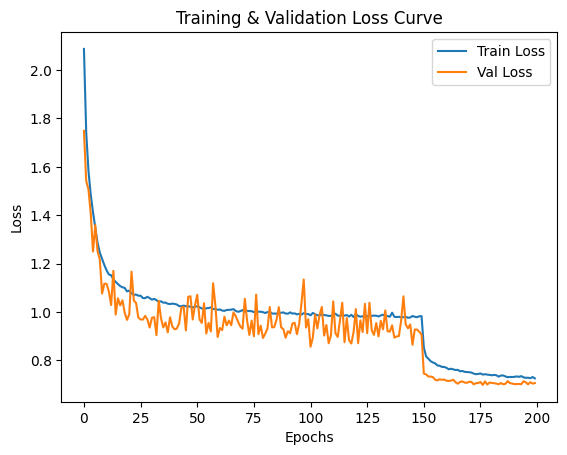

In [ ]:
from tqdm import tqdm

best_acc = 0.0
for epoch in tqdm(range(num_epochs)):
    train(epoch)
    acc = validate(epoch)

    # Save best model checkpoint
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pt")

print(f"Training complete. Best validation accuracy: {best_acc:.2f}%")




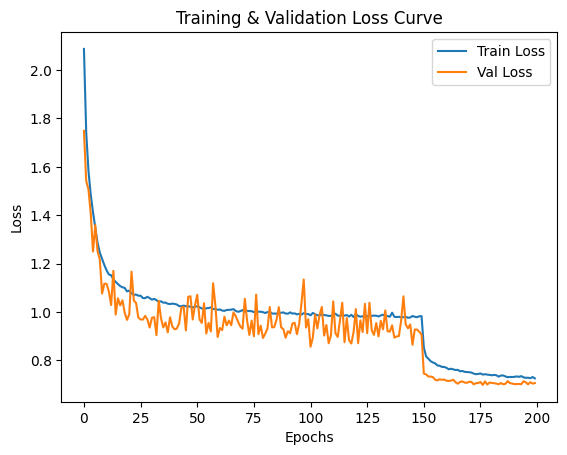

In [ ]:
# -----------------------------------------------------------------------------
# Loss Curve
# -----------------------------------------------------------------------------
plt.figure(1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "project1_model.pt")

# -----------------------------------------------------------------------------
# Inference on Unlabeled Test Set (cifar_test_nolabel.pkl)
# -----------------------------------------------------------------------------
import os
from torch.utils.data import DataLoader, TensorDataset
import pickle
import pandas as pd


In [ ]:
import torch
from tqdm import tqdm

# -------------------------------------------------------------------------
# 1) Load your previously saved best weights.
# -------------------------------------------------------------------------
model.load_state_dict(torch.load("project1_model.pt"))

# If you want to keep the same optimizer state, you could also load it from
# a checkpoint (if previously saved). Otherwise, you'll just continue
# training with a freshly initialized optimizer.

# -------------------------------------------------------------------------
# 2) Train for 100 more epochs
#    (simply extend your training loop; the rest of the code is unchanged)
# -------------------------------------------------------------------------
extra_epochs = 100
best_acc = 0.0  # Reset best_acc or track separately

for epoch in tqdm(range(extra_epochs)):
    # Use your existing `train` function and pass the current epoch index.
    train(epoch)

    # Use your existing `validate` function.
    acc = validate(epoch)

    # If you want to keep saving the best weights in these extra epochs:
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model_continued.pt")

print(f"Additional training complete. Best validation accuracy in extra epochs: {best_acc:.2f}%")

# -------------------------------------------------------------------------
# 3) (Optional) Save final model again after these extra epochs
# -------------------------------------------------------------------------
torch.save(model.state_dict(), "project1_model_extended.pt")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/200], Step [100/782], Loss: 0.6483
Epoch [1/200], Step [200/782], Loss: 0.7249
Epoch [1/200], Step [300/782], Loss: 0.6632
Epoch [1/200], Step [400/782], Loss: 0.6756
Epoch [1/200], Step [500/782], Loss: 0.6073
Epoch [1/200], Step [600/782], Loss: 0.8180
Epoch [1/200], Step [700/782], Loss: 0.7724


  1%|          | 1/100 [00:24<40:23, 24.48s/it]

Validation Epoch [1/200] - Loss: 0.7070, Accuracy: 93.53%
Epoch [2/200], Step [100/782], Loss: 0.7132
Epoch [2/200], Step [200/782], Loss: 0.7215
Epoch [2/200], Step [300/782], Loss: 0.6814
Epoch [2/200], Step [400/782], Loss: 0.8186
Epoch [2/200], Step [500/782], Loss: 0.6901
Epoch [2/200], Step [600/782], Loss: 0.7050
Epoch [2/200], Step [700/782], Loss: 0.6527


  2%|▏         | 2/100 [00:49<40:10, 24.60s/it]

Validation Epoch [2/200] - Loss: 0.7104, Accuracy: 93.48%
Epoch [3/200], Step [100/782], Loss: 0.7397
Epoch [3/200], Step [200/782], Loss: 0.7144
Epoch [3/200], Step [300/782], Loss: 0.9172
Epoch [3/200], Step [400/782], Loss: 0.8324
Epoch [3/200], Step [500/782], Loss: 0.7606
Epoch [3/200], Step [600/782], Loss: 0.7026
Epoch [3/200], Step [700/782], Loss: 0.7325


  3%|▎         | 3/100 [01:13<39:43, 24.57s/it]

Validation Epoch [3/200] - Loss: 0.7129, Accuracy: 93.40%
Epoch [4/200], Step [100/782], Loss: 0.6652
Epoch [4/200], Step [200/782], Loss: 0.8027
Epoch [4/200], Step [300/782], Loss: 0.8128
Epoch [4/200], Step [400/782], Loss: 0.7908
Epoch [4/200], Step [500/782], Loss: 0.7284
Epoch [4/200], Step [600/782], Loss: 0.6798
Epoch [4/200], Step [700/782], Loss: 0.7679


  4%|▍         | 4/100 [01:37<39:03, 24.41s/it]

Validation Epoch [4/200] - Loss: 0.7055, Accuracy: 93.50%
Epoch [5/200], Step [100/782], Loss: 0.7301
Epoch [5/200], Step [200/782], Loss: 0.6236
Epoch [5/200], Step [300/782], Loss: 0.7823
Epoch [5/200], Step [400/782], Loss: 0.7202
Epoch [5/200], Step [500/782], Loss: 0.7231
Epoch [5/200], Step [600/782], Loss: 0.8248
Epoch [5/200], Step [700/782], Loss: 0.7615


  5%|▌         | 5/100 [02:02<38:32, 24.34s/it]

Validation Epoch [5/200] - Loss: 0.7062, Accuracy: 93.63%
Epoch [6/200], Step [100/782], Loss: 0.5910
Epoch [6/200], Step [200/782], Loss: 0.7142
Epoch [6/200], Step [300/782], Loss: 0.7571
Epoch [6/200], Step [400/782], Loss: 0.7964
Epoch [6/200], Step [500/782], Loss: 0.6590
Epoch [6/200], Step [600/782], Loss: 0.7183
Epoch [6/200], Step [700/782], Loss: 0.7026


  6%|▌         | 6/100 [02:26<38:03, 24.29s/it]

Validation Epoch [6/200] - Loss: 0.7067, Accuracy: 93.66%
Epoch [7/200], Step [100/782], Loss: 0.7666
Epoch [7/200], Step [200/782], Loss: 0.8002
Epoch [7/200], Step [300/782], Loss: 0.7057
Epoch [7/200], Step [400/782], Loss: 0.7638
Epoch [7/200], Step [500/782], Loss: 0.7080
Epoch [7/200], Step [600/782], Loss: 0.7087
Epoch [7/200], Step [700/782], Loss: 0.7143


  7%|▋         | 7/100 [02:50<37:31, 24.21s/it]

Validation Epoch [7/200] - Loss: 0.7078, Accuracy: 93.53%
Epoch [8/200], Step [100/782], Loss: 0.7119
Epoch [8/200], Step [200/782], Loss: 0.6827
Epoch [8/200], Step [300/782], Loss: 0.7548
Epoch [8/200], Step [400/782], Loss: 0.7805
Epoch [8/200], Step [500/782], Loss: 0.6841
Epoch [8/200], Step [600/782], Loss: 0.7362
Epoch [8/200], Step [700/782], Loss: 0.6640


  8%|▊         | 8/100 [03:14<37:19, 24.34s/it]

Validation Epoch [8/200] - Loss: 0.7012, Accuracy: 93.73%
Epoch [9/200], Step [100/782], Loss: 0.7267
Epoch [9/200], Step [200/782], Loss: 0.8064
Epoch [9/200], Step [300/782], Loss: 0.7535
Epoch [9/200], Step [400/782], Loss: 0.6733
Epoch [9/200], Step [500/782], Loss: 0.6954
Epoch [9/200], Step [600/782], Loss: 0.7429
Epoch [9/200], Step [700/782], Loss: 0.6688


  9%|▉         | 9/100 [03:38<36:44, 24.23s/it]

Validation Epoch [9/200] - Loss: 0.7116, Accuracy: 92.81%
Epoch [10/200], Step [100/782], Loss: 0.7606
Epoch [10/200], Step [200/782], Loss: 0.7120
Epoch [10/200], Step [300/782], Loss: 0.7352
Epoch [10/200], Step [400/782], Loss: 0.6714
Epoch [10/200], Step [500/782], Loss: 0.7399
Epoch [10/200], Step [600/782], Loss: 0.7137
Epoch [10/200], Step [700/782], Loss: 0.7225


 10%|█         | 10/100 [04:03<36:17, 24.19s/it]

Validation Epoch [10/200] - Loss: 0.7089, Accuracy: 93.70%
Epoch [11/200], Step [100/782], Loss: 0.7212
Epoch [11/200], Step [200/782], Loss: 0.7831
Epoch [11/200], Step [300/782], Loss: 0.7246
Epoch [11/200], Step [400/782], Loss: 0.6941
Epoch [11/200], Step [500/782], Loss: 0.7235
Epoch [11/200], Step [600/782], Loss: 0.7589
Epoch [11/200], Step [700/782], Loss: 0.7086


 11%|█         | 11/100 [04:28<36:15, 24.44s/it]

Validation Epoch [11/200] - Loss: 0.7171, Accuracy: 93.31%
Epoch [12/200], Step [100/782], Loss: 0.7578
Epoch [12/200], Step [200/782], Loss: 0.8299
Epoch [12/200], Step [300/782], Loss: 0.7176
Epoch [12/200], Step [400/782], Loss: 0.7160
Epoch [12/200], Step [500/782], Loss: 0.7592
Epoch [12/200], Step [600/782], Loss: 0.8569
Epoch [12/200], Step [700/782], Loss: 0.6972


 12%|█▏        | 12/100 [04:52<36:00, 24.55s/it]

Validation Epoch [12/200] - Loss: 0.7090, Accuracy: 93.61%
Epoch [13/200], Step [100/782], Loss: 0.7011
Epoch [13/200], Step [200/782], Loss: 0.7063
Epoch [13/200], Step [300/782], Loss: 0.6676
Epoch [13/200], Step [400/782], Loss: 0.7719
Epoch [13/200], Step [500/782], Loss: 0.7815
Epoch [13/200], Step [600/782], Loss: 0.7780
Epoch [13/200], Step [700/782], Loss: 0.8420


 13%|█▎        | 13/100 [05:17<35:44, 24.65s/it]

Validation Epoch [13/200] - Loss: 0.7204, Accuracy: 93.14%
Epoch [14/200], Step [100/782], Loss: 0.7839
Epoch [14/200], Step [200/782], Loss: 0.8693
Epoch [14/200], Step [300/782], Loss: 0.7579
Epoch [14/200], Step [400/782], Loss: 0.7602
Epoch [14/200], Step [500/782], Loss: 0.7425
Epoch [14/200], Step [600/782], Loss: 0.7052
Epoch [14/200], Step [700/782], Loss: 0.7494


 14%|█▍        | 14/100 [05:41<35:09, 24.53s/it]

Validation Epoch [14/200] - Loss: 0.7017, Accuracy: 93.53%
Epoch [15/200], Step [100/782], Loss: 0.7344
Epoch [15/200], Step [200/782], Loss: 0.7154
Epoch [15/200], Step [300/782], Loss: 0.7473
Epoch [15/200], Step [400/782], Loss: 0.7004
Epoch [15/200], Step [500/782], Loss: 0.8063
Epoch [15/200], Step [600/782], Loss: 0.6610
Epoch [15/200], Step [700/782], Loss: 0.7243


 15%|█▌        | 15/100 [06:06<34:52, 24.62s/it]

Validation Epoch [15/200] - Loss: 0.7072, Accuracy: 93.78%
Epoch [16/200], Step [100/782], Loss: 0.7122
Epoch [16/200], Step [200/782], Loss: 0.6656
Epoch [16/200], Step [300/782], Loss: 0.6978
Epoch [16/200], Step [400/782], Loss: 0.7390
Epoch [16/200], Step [500/782], Loss: 0.7236
Epoch [16/200], Step [600/782], Loss: 0.6961
Epoch [16/200], Step [700/782], Loss: 0.7295


 16%|█▌        | 16/100 [06:31<34:41, 24.78s/it]

Validation Epoch [16/200] - Loss: 0.7114, Accuracy: 93.29%
Epoch [17/200], Step [100/782], Loss: 0.6774
Epoch [17/200], Step [200/782], Loss: 0.7046
Epoch [17/200], Step [300/782], Loss: 0.6676
Epoch [17/200], Step [400/782], Loss: 0.7335
Epoch [17/200], Step [500/782], Loss: 0.7432
Epoch [17/200], Step [600/782], Loss: 0.7277
Epoch [17/200], Step [700/782], Loss: 0.7025


 17%|█▋        | 17/100 [06:56<34:16, 24.78s/it]

Validation Epoch [17/200] - Loss: 0.7172, Accuracy: 93.27%
Epoch [18/200], Step [100/782], Loss: 0.7111
Epoch [18/200], Step [200/782], Loss: 0.7904
Epoch [18/200], Step [300/782], Loss: 0.6948
Epoch [18/200], Step [400/782], Loss: 0.7475
Epoch [18/200], Step [500/782], Loss: 0.8232
Epoch [18/200], Step [600/782], Loss: 0.7082
Epoch [18/200], Step [700/782], Loss: 0.7430


 18%|█▊        | 18/100 [07:21<33:45, 24.71s/it]

Validation Epoch [18/200] - Loss: 0.7151, Accuracy: 93.38%
Epoch [19/200], Step [100/782], Loss: 0.7807
Epoch [19/200], Step [200/782], Loss: 0.7561
Epoch [19/200], Step [300/782], Loss: 0.8453
Epoch [19/200], Step [400/782], Loss: 0.7310
Epoch [19/200], Step [500/782], Loss: 0.8033
Epoch [19/200], Step [600/782], Loss: 0.7244
Epoch [19/200], Step [700/782], Loss: 0.6532


 19%|█▉        | 19/100 [07:45<33:06, 24.52s/it]

Validation Epoch [19/200] - Loss: 0.7194, Accuracy: 92.90%
Epoch [20/200], Step [100/782], Loss: 0.7977
Epoch [20/200], Step [200/782], Loss: 0.6382
Epoch [20/200], Step [300/782], Loss: 0.6685
Epoch [20/200], Step [400/782], Loss: 0.8036
Epoch [20/200], Step [500/782], Loss: 0.6524
Epoch [20/200], Step [600/782], Loss: 0.7478
Epoch [20/200], Step [700/782], Loss: 0.6565


 20%|██        | 20/100 [08:10<32:49, 24.61s/it]

Validation Epoch [20/200] - Loss: 0.7092, Accuracy: 93.44%
Epoch [21/200], Step [100/782], Loss: 0.7094
Epoch [21/200], Step [200/782], Loss: 0.8387
Epoch [21/200], Step [300/782], Loss: 0.7270
Epoch [21/200], Step [400/782], Loss: 0.7102
Epoch [21/200], Step [500/782], Loss: 0.6545
Epoch [21/200], Step [600/782], Loss: 0.5968
Epoch [21/200], Step [700/782], Loss: 0.7349


 21%|██        | 21/100 [08:35<32:29, 24.68s/it]

Validation Epoch [21/200] - Loss: 0.7133, Accuracy: 93.51%
Epoch [22/200], Step [100/782], Loss: 0.7337
Epoch [22/200], Step [200/782], Loss: 0.7250
Epoch [22/200], Step [300/782], Loss: 0.7675
Epoch [22/200], Step [400/782], Loss: 0.7007
Epoch [22/200], Step [500/782], Loss: 0.7265
Epoch [22/200], Step [600/782], Loss: 0.6521
Epoch [22/200], Step [700/782], Loss: 0.7133


 22%|██▏       | 22/100 [08:59<32:06, 24.70s/it]

Validation Epoch [22/200] - Loss: 0.7171, Accuracy: 93.07%
Epoch [23/200], Step [100/782], Loss: 0.6758
Epoch [23/200], Step [200/782], Loss: 0.7264
Epoch [23/200], Step [300/782], Loss: 0.6778
Epoch [23/200], Step [400/782], Loss: 0.8567
Epoch [23/200], Step [500/782], Loss: 0.7402
Epoch [23/200], Step [600/782], Loss: 0.8384
Epoch [23/200], Step [700/782], Loss: 0.6855


 23%|██▎       | 23/100 [09:26<32:27, 25.29s/it]

Validation Epoch [23/200] - Loss: 0.6998, Accuracy: 93.72%
Epoch [24/200], Step [100/782], Loss: 0.7800
Epoch [24/200], Step [200/782], Loss: 0.7261
Epoch [24/200], Step [300/782], Loss: 0.8178
Epoch [24/200], Step [400/782], Loss: 0.7631
Epoch [24/200], Step [500/782], Loss: 0.7116
Epoch [24/200], Step [600/782], Loss: 0.7543
Epoch [24/200], Step [700/782], Loss: 0.6536


 24%|██▍       | 24/100 [09:50<31:39, 24.99s/it]

Validation Epoch [24/200] - Loss: 0.7077, Accuracy: 93.65%
Epoch [25/200], Step [100/782], Loss: 0.8430
Epoch [25/200], Step [200/782], Loss: 0.7131
Epoch [25/200], Step [300/782], Loss: 0.7646
Epoch [25/200], Step [400/782], Loss: 0.7013
Epoch [25/200], Step [500/782], Loss: 0.7178
Epoch [25/200], Step [600/782], Loss: 0.7916
Epoch [25/200], Step [700/782], Loss: 0.7349


 25%|██▌       | 25/100 [10:15<31:00, 24.80s/it]

Validation Epoch [25/200] - Loss: 0.7021, Accuracy: 93.79%
Epoch [26/200], Step [100/782], Loss: 0.7161
Epoch [26/200], Step [200/782], Loss: 0.6805
Epoch [26/200], Step [300/782], Loss: 0.7224
Epoch [26/200], Step [400/782], Loss: 0.6142
Epoch [26/200], Step [500/782], Loss: 0.7377
Epoch [26/200], Step [600/782], Loss: 0.6154
Epoch [26/200], Step [700/782], Loss: 0.6637


 26%|██▌       | 26/100 [10:39<30:37, 24.84s/it]

Validation Epoch [26/200] - Loss: 0.6872, Accuracy: 94.25%
Epoch [27/200], Step [100/782], Loss: 0.5884
Epoch [27/200], Step [200/782], Loss: 0.6573
Epoch [27/200], Step [300/782], Loss: 0.7219
Epoch [27/200], Step [400/782], Loss: 0.6351
Epoch [27/200], Step [500/782], Loss: 0.7288
Epoch [27/200], Step [600/782], Loss: 0.6639
Epoch [27/200], Step [700/782], Loss: 0.6453


 27%|██▋       | 27/100 [11:04<29:58, 24.63s/it]

Validation Epoch [27/200] - Loss: 0.6812, Accuracy: 94.45%
Epoch [28/200], Step [100/782], Loss: 0.7622
Epoch [28/200], Step [200/782], Loss: 0.6832
Epoch [28/200], Step [300/782], Loss: 0.6244
Epoch [28/200], Step [400/782], Loss: 0.6980
Epoch [28/200], Step [500/782], Loss: 0.6290
Epoch [28/200], Step [600/782], Loss: 0.6345
Epoch [28/200], Step [700/782], Loss: 0.6531


 28%|██▊       | 28/100 [11:28<29:24, 24.51s/it]

Validation Epoch [28/200] - Loss: 0.6785, Accuracy: 94.52%
Epoch [29/200], Step [100/782], Loss: 0.6883
Epoch [29/200], Step [200/782], Loss: 0.7163
Epoch [29/200], Step [300/782], Loss: 0.6889
Epoch [29/200], Step [400/782], Loss: 0.6810
Epoch [29/200], Step [500/782], Loss: 0.6809
Epoch [29/200], Step [600/782], Loss: 0.7186
Epoch [29/200], Step [700/782], Loss: 0.6723
Validation Epoch [29/200] - Loss: 0.6770, Accuracy: 94.55%


 29%|██▉       | 29/100 [11:52<28:59, 24.50s/it]

Epoch [30/200], Step [100/782], Loss: 0.7533
Epoch [30/200], Step [200/782], Loss: 0.6539
Epoch [30/200], Step [300/782], Loss: 0.6113
Epoch [30/200], Step [400/782], Loss: 0.7076
Epoch [30/200], Step [500/782], Loss: 0.7643
Epoch [30/200], Step [600/782], Loss: 0.6328
Epoch [30/200], Step [700/782], Loss: 0.6989


 30%|███       | 30/100 [12:17<28:43, 24.63s/it]

Validation Epoch [30/200] - Loss: 0.6792, Accuracy: 94.50%
Epoch [31/200], Step [100/782], Loss: 0.6340
Epoch [31/200], Step [200/782], Loss: 0.6265
Epoch [31/200], Step [300/782], Loss: 0.6788
Epoch [31/200], Step [400/782], Loss: 0.6555
Epoch [31/200], Step [500/782], Loss: 0.6817
Epoch [31/200], Step [600/782], Loss: 0.6273
Epoch [31/200], Step [700/782], Loss: 0.7207
Validation Epoch [31/200] - Loss: 0.6774, Accuracy: 94.65%


 31%|███       | 31/100 [12:42<28:17, 24.60s/it]

Epoch [32/200], Step [100/782], Loss: 0.6156
Epoch [32/200], Step [200/782], Loss: 0.6225
Epoch [32/200], Step [300/782], Loss: 0.6917
Epoch [32/200], Step [400/782], Loss: 0.6367
Epoch [32/200], Step [500/782], Loss: 0.6683
Epoch [32/200], Step [600/782], Loss: 0.6495
Epoch [32/200], Step [700/782], Loss: 0.6345


 32%|███▏      | 32/100 [13:06<27:54, 24.62s/it]

Validation Epoch [32/200] - Loss: 0.6774, Accuracy: 94.50%
Epoch [33/200], Step [100/782], Loss: 0.6595
Epoch [33/200], Step [200/782], Loss: 0.6773
Epoch [33/200], Step [300/782], Loss: 0.6655
Epoch [33/200], Step [400/782], Loss: 0.6679
Epoch [33/200], Step [500/782], Loss: 0.7622
Epoch [33/200], Step [600/782], Loss: 0.7142
Epoch [33/200], Step [700/782], Loss: 0.6201


 33%|███▎      | 33/100 [13:31<27:18, 24.45s/it]

Validation Epoch [33/200] - Loss: 0.6748, Accuracy: 94.48%
Epoch [34/200], Step [100/782], Loss: 0.6357
Epoch [34/200], Step [200/782], Loss: 0.7333
Epoch [34/200], Step [300/782], Loss: 0.6610
Epoch [34/200], Step [400/782], Loss: 0.6700
Epoch [34/200], Step [500/782], Loss: 0.6968
Epoch [34/200], Step [600/782], Loss: 0.6537
Epoch [34/200], Step [700/782], Loss: 0.6955


 34%|███▍      | 34/100 [13:55<26:47, 24.36s/it]

Validation Epoch [34/200] - Loss: 0.6772, Accuracy: 94.53%
Epoch [35/200], Step [100/782], Loss: 0.6871
Epoch [35/200], Step [200/782], Loss: 0.7810
Epoch [35/200], Step [300/782], Loss: 0.6346
Epoch [35/200], Step [400/782], Loss: 0.7320
Epoch [35/200], Step [500/782], Loss: 0.6920
Epoch [35/200], Step [600/782], Loss: 0.6653
Epoch [35/200], Step [700/782], Loss: 0.6818


 35%|███▌      | 35/100 [14:19<26:19, 24.29s/it]

Validation Epoch [35/200] - Loss: 0.6732, Accuracy: 94.65%
Epoch [36/200], Step [100/782], Loss: 0.7165
Epoch [36/200], Step [200/782], Loss: 0.6623
Epoch [36/200], Step [300/782], Loss: 0.7449
Epoch [36/200], Step [400/782], Loss: 0.7407
Epoch [36/200], Step [500/782], Loss: 0.6822
Epoch [36/200], Step [600/782], Loss: 0.8205
Epoch [36/200], Step [700/782], Loss: 0.6618


 36%|███▌      | 36/100 [14:43<25:53, 24.28s/it]

Validation Epoch [36/200] - Loss: 0.6772, Accuracy: 94.58%
Epoch [37/200], Step [100/782], Loss: 0.6795
Epoch [37/200], Step [200/782], Loss: 0.6668
Epoch [37/200], Step [300/782], Loss: 0.6824
Epoch [37/200], Step [400/782], Loss: 0.6568
Epoch [37/200], Step [500/782], Loss: 0.6479
Epoch [37/200], Step [600/782], Loss: 0.6368
Epoch [37/200], Step [700/782], Loss: 0.6448


 37%|███▋      | 37/100 [15:08<25:37, 24.41s/it]

Validation Epoch [37/200] - Loss: 0.6746, Accuracy: 94.52%
Epoch [38/200], Step [100/782], Loss: 0.6514
Epoch [38/200], Step [200/782], Loss: 0.6846
Epoch [38/200], Step [300/782], Loss: 0.7511
Epoch [38/200], Step [400/782], Loss: 0.7823
Epoch [38/200], Step [500/782], Loss: 0.6866
Epoch [38/200], Step [600/782], Loss: 0.6828
Epoch [38/200], Step [700/782], Loss: 0.7707


 38%|███▊      | 38/100 [15:33<25:21, 24.54s/it]

Validation Epoch [38/200] - Loss: 0.6759, Accuracy: 94.43%
Epoch [39/200], Step [100/782], Loss: 0.6323
Epoch [39/200], Step [200/782], Loss: 0.6964
Epoch [39/200], Step [300/782], Loss: 0.7327
Epoch [39/200], Step [400/782], Loss: 0.5944
Epoch [39/200], Step [500/782], Loss: 0.6420
Epoch [39/200], Step [600/782], Loss: 0.7384
Epoch [39/200], Step [700/782], Loss: 0.7326


 39%|███▉      | 39/100 [15:57<24:59, 24.58s/it]

Validation Epoch [39/200] - Loss: 0.6745, Accuracy: 94.59%
Epoch [40/200], Step [100/782], Loss: 0.6666
Epoch [40/200], Step [200/782], Loss: 0.6957
Epoch [40/200], Step [300/782], Loss: 0.6628
Epoch [40/200], Step [400/782], Loss: 0.6947
Epoch [40/200], Step [500/782], Loss: 0.6823
Epoch [40/200], Step [600/782], Loss: 0.6899
Epoch [40/200], Step [700/782], Loss: 0.7112


 40%|████      | 40/100 [16:22<24:37, 24.63s/it]

Validation Epoch [40/200] - Loss: 0.6747, Accuracy: 94.59%
Epoch [41/200], Step [100/782], Loss: 0.7384
Epoch [41/200], Step [200/782], Loss: 0.7234
Epoch [41/200], Step [300/782], Loss: 0.6536
Epoch [41/200], Step [400/782], Loss: 0.6552
Epoch [41/200], Step [500/782], Loss: 0.7271
Epoch [41/200], Step [600/782], Loss: 0.6139
Epoch [41/200], Step [700/782], Loss: 0.6855


 41%|████      | 41/100 [16:47<24:20, 24.76s/it]

Validation Epoch [41/200] - Loss: 0.6747, Accuracy: 94.65%
Epoch [42/200], Step [100/782], Loss: 0.7147
Epoch [42/200], Step [200/782], Loss: 0.6059
Epoch [42/200], Step [300/782], Loss: 0.6315
Epoch [42/200], Step [400/782], Loss: 0.6993
Epoch [42/200], Step [500/782], Loss: 0.6130
Epoch [42/200], Step [600/782], Loss: 0.6903
Epoch [42/200], Step [700/782], Loss: 0.6558


 42%|████▏     | 42/100 [17:11<23:48, 24.63s/it]

Validation Epoch [42/200] - Loss: 0.6749, Accuracy: 94.72%
Epoch [43/200], Step [100/782], Loss: 0.6415
Epoch [43/200], Step [200/782], Loss: 0.7150
Epoch [43/200], Step [300/782], Loss: 0.6861
Epoch [43/200], Step [400/782], Loss: 0.6082
Epoch [43/200], Step [500/782], Loss: 0.7142
Epoch [43/200], Step [600/782], Loss: 0.6860
Epoch [43/200], Step [700/782], Loss: 0.6383


 43%|████▎     | 43/100 [17:36<23:16, 24.49s/it]

Validation Epoch [43/200] - Loss: 0.6747, Accuracy: 94.69%
Epoch [44/200], Step [100/782], Loss: 0.6651
Epoch [44/200], Step [200/782], Loss: 0.6667
Epoch [44/200], Step [300/782], Loss: 0.6952
Epoch [44/200], Step [400/782], Loss: 0.6852
Epoch [44/200], Step [500/782], Loss: 0.6883
Epoch [44/200], Step [600/782], Loss: 0.5877
Epoch [44/200], Step [700/782], Loss: 0.6161


 44%|████▍     | 44/100 [18:01<23:05, 24.74s/it]

Validation Epoch [44/200] - Loss: 0.6760, Accuracy: 94.77%
Epoch [45/200], Step [100/782], Loss: 0.6719
Epoch [45/200], Step [200/782], Loss: 0.6288
Epoch [45/200], Step [300/782], Loss: 0.7092
Epoch [45/200], Step [400/782], Loss: 0.6086
Epoch [45/200], Step [500/782], Loss: 0.6869
Epoch [45/200], Step [600/782], Loss: 0.6855
Epoch [45/200], Step [700/782], Loss: 0.7807


 45%|████▌     | 45/100 [18:25<22:31, 24.57s/it]

Validation Epoch [45/200] - Loss: 0.6759, Accuracy: 94.72%
Epoch [46/200], Step [100/782], Loss: 0.6576
Epoch [46/200], Step [200/782], Loss: 0.7818
Epoch [46/200], Step [300/782], Loss: 0.6019
Epoch [46/200], Step [400/782], Loss: 0.6001
Epoch [46/200], Step [500/782], Loss: 0.6315
Epoch [46/200], Step [600/782], Loss: 0.7117
Epoch [46/200], Step [700/782], Loss: 0.6519


 46%|████▌     | 46/100 [18:49<21:58, 24.41s/it]

Validation Epoch [46/200] - Loss: 0.6737, Accuracy: 94.72%
Epoch [47/200], Step [100/782], Loss: 0.6794
Epoch [47/200], Step [200/782], Loss: 0.6180
Epoch [47/200], Step [300/782], Loss: 0.6746
Epoch [47/200], Step [400/782], Loss: 0.7741
Epoch [47/200], Step [500/782], Loss: 0.6975
Epoch [47/200], Step [600/782], Loss: 0.5881
Epoch [47/200], Step [700/782], Loss: 0.6803


 47%|████▋     | 47/100 [19:13<21:28, 24.31s/it]

Validation Epoch [47/200] - Loss: 0.6743, Accuracy: 94.65%
Epoch [48/200], Step [100/782], Loss: 0.7107
Epoch [48/200], Step [200/782], Loss: 0.6190
Epoch [48/200], Step [300/782], Loss: 0.7161
Epoch [48/200], Step [400/782], Loss: 0.6826
Epoch [48/200], Step [500/782], Loss: 0.6436
Epoch [48/200], Step [600/782], Loss: 0.6217
Epoch [48/200], Step [700/782], Loss: 0.6566


 48%|████▊     | 48/100 [19:38<21:09, 24.41s/it]

Validation Epoch [48/200] - Loss: 0.6744, Accuracy: 94.81%
Epoch [49/200], Step [100/782], Loss: 0.6372
Epoch [49/200], Step [200/782], Loss: 0.6312
Epoch [49/200], Step [300/782], Loss: 0.6563
Epoch [49/200], Step [400/782], Loss: 0.7138
Epoch [49/200], Step [500/782], Loss: 0.6964
Epoch [49/200], Step [600/782], Loss: 0.6787
Epoch [49/200], Step [700/782], Loss: 0.6585


 49%|████▉     | 49/100 [20:02<20:48, 24.47s/it]

Validation Epoch [49/200] - Loss: 0.6734, Accuracy: 94.78%
Epoch [50/200], Step [100/782], Loss: 0.7183
Epoch [50/200], Step [200/782], Loss: 0.6556
Epoch [50/200], Step [300/782], Loss: 0.7003
Epoch [50/200], Step [400/782], Loss: 0.6216
Epoch [50/200], Step [500/782], Loss: 0.6351
Epoch [50/200], Step [600/782], Loss: 0.6873
Epoch [50/200], Step [700/782], Loss: 0.6410


 50%|█████     | 50/100 [20:27<20:30, 24.61s/it]

Validation Epoch [50/200] - Loss: 0.6718, Accuracy: 94.73%
Epoch [51/200], Step [100/782], Loss: 0.6580
Epoch [51/200], Step [200/782], Loss: 0.8664
Epoch [51/200], Step [300/782], Loss: 0.7078
Epoch [51/200], Step [400/782], Loss: 0.6065
Epoch [51/200], Step [500/782], Loss: 0.6216
Epoch [51/200], Step [600/782], Loss: 0.6420
Epoch [51/200], Step [700/782], Loss: 0.6950


 51%|█████     | 51/100 [20:52<20:02, 24.55s/it]

Validation Epoch [51/200] - Loss: 0.6750, Accuracy: 94.68%
Epoch [52/200], Step [100/782], Loss: 0.6397
Epoch [52/200], Step [200/782], Loss: 0.6481
Epoch [52/200], Step [300/782], Loss: 0.6208
Epoch [52/200], Step [400/782], Loss: 0.5992
Epoch [52/200], Step [500/782], Loss: 0.7213
Epoch [52/200], Step [600/782], Loss: 0.6449
Epoch [52/200], Step [700/782], Loss: 0.6705


 52%|█████▏    | 52/100 [21:17<19:40, 24.60s/it]

Validation Epoch [52/200] - Loss: 0.6713, Accuracy: 94.75%
Epoch [53/200], Step [100/782], Loss: 0.7187
Epoch [53/200], Step [200/782], Loss: 0.7061
Epoch [53/200], Step [300/782], Loss: 0.6198
Epoch [53/200], Step [400/782], Loss: 0.6634
Epoch [53/200], Step [500/782], Loss: 0.7171
Epoch [53/200], Step [600/782], Loss: 0.6677
Epoch [53/200], Step [700/782], Loss: 0.7108


 53%|█████▎    | 53/100 [21:41<19:19, 24.66s/it]

Validation Epoch [53/200] - Loss: 0.6737, Accuracy: 94.58%
Epoch [54/200], Step [100/782], Loss: 0.7031
Epoch [54/200], Step [200/782], Loss: 0.6856
Epoch [54/200], Step [300/782], Loss: 0.6679
Epoch [54/200], Step [400/782], Loss: 0.6256
Epoch [54/200], Step [500/782], Loss: 0.6582
Epoch [54/200], Step [600/782], Loss: 0.6168
Epoch [54/200], Step [700/782], Loss: 0.6926


 54%|█████▍    | 54/100 [22:06<18:49, 24.56s/it]

Validation Epoch [54/200] - Loss: 0.6753, Accuracy: 94.66%
Epoch [55/200], Step [100/782], Loss: 0.6839
Epoch [55/200], Step [200/782], Loss: 0.6523
Epoch [55/200], Step [300/782], Loss: 0.7031
Epoch [55/200], Step [400/782], Loss: 0.6569
Epoch [55/200], Step [500/782], Loss: 0.6611
Epoch [55/200], Step [600/782], Loss: 0.6339
Epoch [55/200], Step [700/782], Loss: 0.7532


 55%|█████▌    | 55/100 [22:30<18:19, 24.43s/it]

Validation Epoch [55/200] - Loss: 0.6714, Accuracy: 94.72%
Epoch [56/200], Step [100/782], Loss: 0.6427
Epoch [56/200], Step [200/782], Loss: 0.6029
Epoch [56/200], Step [300/782], Loss: 0.6245
Epoch [56/200], Step [400/782], Loss: 0.6004
Epoch [56/200], Step [500/782], Loss: 0.6458
Epoch [56/200], Step [600/782], Loss: 0.7105
Epoch [56/200], Step [700/782], Loss: 0.6991


 56%|█████▌    | 56/100 [22:55<18:00, 24.55s/it]

Validation Epoch [56/200] - Loss: 0.6723, Accuracy: 94.85%
Epoch [57/200], Step [100/782], Loss: 0.6868
Epoch [57/200], Step [200/782], Loss: 0.6907
Epoch [57/200], Step [300/782], Loss: 0.6588
Epoch [57/200], Step [400/782], Loss: 0.5962
Epoch [57/200], Step [500/782], Loss: 0.6348
Epoch [57/200], Step [600/782], Loss: 0.6981
Epoch [57/200], Step [700/782], Loss: 0.5587


 57%|█████▋    | 57/100 [23:19<17:39, 24.64s/it]

Validation Epoch [57/200] - Loss: 0.6726, Accuracy: 94.77%
Epoch [58/200], Step [100/782], Loss: 0.6847
Epoch [58/200], Step [200/782], Loss: 0.6492
Epoch [58/200], Step [300/782], Loss: 0.8051
Epoch [58/200], Step [400/782], Loss: 0.6236
Epoch [58/200], Step [500/782], Loss: 0.5840
Epoch [58/200], Step [600/782], Loss: 0.6822
Epoch [58/200], Step [700/782], Loss: 0.6495


 58%|█████▊    | 58/100 [23:44<17:17, 24.71s/it]

Validation Epoch [58/200] - Loss: 0.6734, Accuracy: 94.70%
Epoch [59/200], Step [100/782], Loss: 0.6754
Epoch [59/200], Step [200/782], Loss: 0.5834
Epoch [59/200], Step [300/782], Loss: 0.6445
Epoch [59/200], Step [400/782], Loss: 0.6903
Epoch [59/200], Step [500/782], Loss: 0.5940
Epoch [59/200], Step [600/782], Loss: 0.5954
Epoch [59/200], Step [700/782], Loss: 0.6065


 59%|█████▉    | 59/100 [24:09<16:49, 24.62s/it]

Validation Epoch [59/200] - Loss: 0.6730, Accuracy: 94.90%
Epoch [60/200], Step [100/782], Loss: 0.5859
Epoch [60/200], Step [200/782], Loss: 0.7492
Epoch [60/200], Step [300/782], Loss: 0.6733
Epoch [60/200], Step [400/782], Loss: 0.6621
Epoch [60/200], Step [500/782], Loss: 0.6709
Epoch [60/200], Step [600/782], Loss: 0.6832
Epoch [60/200], Step [700/782], Loss: 0.7022


 60%|██████    | 60/100 [24:33<16:19, 24.49s/it]

Validation Epoch [60/200] - Loss: 0.6733, Accuracy: 94.82%
Epoch [61/200], Step [100/782], Loss: 0.7059
Epoch [61/200], Step [200/782], Loss: 0.6247
Epoch [61/200], Step [300/782], Loss: 0.6649
Epoch [61/200], Step [400/782], Loss: 0.7008
Epoch [61/200], Step [500/782], Loss: 0.6535
Epoch [61/200], Step [600/782], Loss: 0.6471
Epoch [61/200], Step [700/782], Loss: 0.6139


 61%|██████    | 61/100 [24:57<15:49, 24.34s/it]

Validation Epoch [61/200] - Loss: 0.6737, Accuracy: 94.80%
Epoch [62/200], Step [100/782], Loss: 0.6847
Epoch [62/200], Step [200/782], Loss: 0.6558
Epoch [62/200], Step [300/782], Loss: 0.6394
Epoch [62/200], Step [400/782], Loss: 0.7348
Epoch [62/200], Step [500/782], Loss: 0.6869
Epoch [62/200], Step [600/782], Loss: 0.6797
Epoch [62/200], Step [700/782], Loss: 0.6708


 62%|██████▏   | 62/100 [25:21<15:22, 24.27s/it]

Validation Epoch [62/200] - Loss: 0.6716, Accuracy: 94.74%
Epoch [63/200], Step [100/782], Loss: 0.6878
Epoch [63/200], Step [200/782], Loss: 0.6400
Epoch [63/200], Step [300/782], Loss: 0.6373
Epoch [63/200], Step [400/782], Loss: 0.6572
Epoch [63/200], Step [500/782], Loss: 0.6234
Epoch [63/200], Step [600/782], Loss: 0.6218
Epoch [63/200], Step [700/782], Loss: 0.6754


 63%|██████▎   | 63/100 [25:46<15:03, 24.41s/it]

Validation Epoch [63/200] - Loss: 0.6737, Accuracy: 94.68%
Epoch [64/200], Step [100/782], Loss: 0.6303
Epoch [64/200], Step [200/782], Loss: 0.7426
Epoch [64/200], Step [300/782], Loss: 0.6524
Epoch [64/200], Step [400/782], Loss: 0.6517
Epoch [64/200], Step [500/782], Loss: 0.6127
Epoch [64/200], Step [600/782], Loss: 0.6445
Epoch [64/200], Step [700/782], Loss: 0.7086


 64%|██████▍   | 64/100 [26:10<14:35, 24.32s/it]

Validation Epoch [64/200] - Loss: 0.6729, Accuracy: 94.72%
Epoch [65/200], Step [100/782], Loss: 0.7217
Epoch [65/200], Step [200/782], Loss: 0.7325
Epoch [65/200], Step [300/782], Loss: 0.6907
Epoch [65/200], Step [400/782], Loss: 0.7332
Epoch [65/200], Step [500/782], Loss: 0.7106
Epoch [65/200], Step [600/782], Loss: 0.6275
Epoch [65/200], Step [700/782], Loss: 0.6119


 65%|██████▌   | 65/100 [26:35<14:15, 24.44s/it]

Validation Epoch [65/200] - Loss: 0.6726, Accuracy: 94.66%
Epoch [66/200], Step [100/782], Loss: 0.6778
Epoch [66/200], Step [200/782], Loss: 0.6711
Epoch [66/200], Step [300/782], Loss: 0.6926
Epoch [66/200], Step [400/782], Loss: 0.6134
Epoch [66/200], Step [500/782], Loss: 0.6282
Epoch [66/200], Step [600/782], Loss: 0.5990
Epoch [66/200], Step [700/782], Loss: 0.6472


 66%|██████▌   | 66/100 [27:00<14:02, 24.78s/it]

Validation Epoch [66/200] - Loss: 0.6721, Accuracy: 94.77%
Epoch [67/200], Step [100/782], Loss: 0.7088
Epoch [67/200], Step [200/782], Loss: 0.6381
Epoch [67/200], Step [300/782], Loss: 0.6494
Epoch [67/200], Step [400/782], Loss: 0.6778
Epoch [67/200], Step [500/782], Loss: 0.7307
Epoch [67/200], Step [600/782], Loss: 0.6931
Epoch [67/200], Step [700/782], Loss: 0.6648


 67%|██████▋   | 67/100 [27:25<13:33, 24.64s/it]

Validation Epoch [67/200] - Loss: 0.6707, Accuracy: 94.82%
Epoch [68/200], Step [100/782], Loss: 0.5905
Epoch [68/200], Step [200/782], Loss: 0.6023
Epoch [68/200], Step [300/782], Loss: 0.7392
Epoch [68/200], Step [400/782], Loss: 0.6543
Epoch [68/200], Step [500/782], Loss: 0.6986
Epoch [68/200], Step [600/782], Loss: 0.6088
Epoch [68/200], Step [700/782], Loss: 0.7037


 68%|██████▊   | 68/100 [27:49<13:04, 24.51s/it]

Validation Epoch [68/200] - Loss: 0.6702, Accuracy: 94.83%
Epoch [69/200], Step [100/782], Loss: 0.6613
Epoch [69/200], Step [200/782], Loss: 0.6140
Epoch [69/200], Step [300/782], Loss: 0.6127
Epoch [69/200], Step [400/782], Loss: 0.6590
Epoch [69/200], Step [500/782], Loss: 0.6771
Epoch [69/200], Step [600/782], Loss: 0.7409
Epoch [69/200], Step [700/782], Loss: 0.6418


 69%|██████▉   | 69/100 [28:14<12:43, 24.63s/it]

Validation Epoch [69/200] - Loss: 0.6712, Accuracy: 94.74%
Epoch [70/200], Step [100/782], Loss: 0.6452
Epoch [70/200], Step [200/782], Loss: 0.6358
Epoch [70/200], Step [300/782], Loss: 0.6708
Epoch [70/200], Step [400/782], Loss: 0.6698
Epoch [70/200], Step [500/782], Loss: 0.6908
Epoch [70/200], Step [600/782], Loss: 0.6309
Epoch [70/200], Step [700/782], Loss: 0.6392


 70%|███████   | 70/100 [28:38<12:14, 24.49s/it]

Validation Epoch [70/200] - Loss: 0.6718, Accuracy: 94.81%
Epoch [71/200], Step [100/782], Loss: 0.7345
Epoch [71/200], Step [200/782], Loss: 0.7080
Epoch [71/200], Step [300/782], Loss: 0.6072
Epoch [71/200], Step [400/782], Loss: 0.6753
Epoch [71/200], Step [500/782], Loss: 0.6133
Epoch [71/200], Step [600/782], Loss: 0.6472
Epoch [71/200], Step [700/782], Loss: 0.6907


 71%|███████   | 71/100 [29:02<11:46, 24.36s/it]

Validation Epoch [71/200] - Loss: 0.6725, Accuracy: 94.71%
Epoch [72/200], Step [100/782], Loss: 0.7457
Epoch [72/200], Step [200/782], Loss: 0.7136
Epoch [72/200], Step [300/782], Loss: 0.6348
Epoch [72/200], Step [400/782], Loss: 0.6643
Epoch [72/200], Step [500/782], Loss: 0.6580
Epoch [72/200], Step [600/782], Loss: 0.7080
Epoch [72/200], Step [700/782], Loss: 0.6683


 72%|███████▏  | 72/100 [29:26<11:20, 24.29s/it]

Validation Epoch [72/200] - Loss: 0.6718, Accuracy: 94.90%
Epoch [73/200], Step [100/782], Loss: 0.6218
Epoch [73/200], Step [200/782], Loss: 0.6786
Epoch [73/200], Step [300/782], Loss: 0.6132
Epoch [73/200], Step [400/782], Loss: 0.6820
Epoch [73/200], Step [500/782], Loss: 0.6112
Epoch [73/200], Step [600/782], Loss: 0.6962
Epoch [73/200], Step [700/782], Loss: 0.6091


 73%|███████▎  | 73/100 [29:50<10:53, 24.21s/it]

Validation Epoch [73/200] - Loss: 0.6708, Accuracy: 94.74%
Epoch [74/200], Step [100/782], Loss: 0.5804
Epoch [74/200], Step [200/782], Loss: 0.6694
Epoch [74/200], Step [300/782], Loss: 0.7057
Epoch [74/200], Step [400/782], Loss: 0.7633
Epoch [74/200], Step [500/782], Loss: 0.7008
Epoch [74/200], Step [600/782], Loss: 0.6148
Epoch [74/200], Step [700/782], Loss: 0.6488


 74%|███████▍  | 74/100 [30:14<10:28, 24.17s/it]

Validation Epoch [74/200] - Loss: 0.6721, Accuracy: 94.68%
Epoch [75/200], Step [100/782], Loss: 0.6055
Epoch [75/200], Step [200/782], Loss: 0.6654
Epoch [75/200], Step [300/782], Loss: 0.7154
Epoch [75/200], Step [400/782], Loss: 0.5823
Epoch [75/200], Step [500/782], Loss: 0.7057
Epoch [75/200], Step [600/782], Loss: 0.6211
Epoch [75/200], Step [700/782], Loss: 0.7765


 75%|███████▌  | 75/100 [30:38<10:04, 24.16s/it]

Validation Epoch [75/200] - Loss: 0.6721, Accuracy: 94.79%
Epoch [76/200], Step [100/782], Loss: 0.6242
Epoch [76/200], Step [200/782], Loss: 0.7041
Epoch [76/200], Step [300/782], Loss: 0.6325
Epoch [76/200], Step [400/782], Loss: 0.6427
Epoch [76/200], Step [500/782], Loss: 0.6877
Epoch [76/200], Step [600/782], Loss: 0.6722
Epoch [76/200], Step [700/782], Loss: 0.6975


 76%|███████▌  | 76/100 [31:02<09:39, 24.16s/it]

Validation Epoch [76/200] - Loss: 0.6692, Accuracy: 94.88%
Epoch [77/200], Step [100/782], Loss: 0.6190
Epoch [77/200], Step [200/782], Loss: 0.6198
Epoch [77/200], Step [300/782], Loss: 0.6855
Epoch [77/200], Step [400/782], Loss: 0.6977
Epoch [77/200], Step [500/782], Loss: 0.6491
Epoch [77/200], Step [600/782], Loss: 0.7142
Epoch [77/200], Step [700/782], Loss: 0.7398


 77%|███████▋  | 77/100 [31:27<09:17, 24.23s/it]

Validation Epoch [77/200] - Loss: 0.6694, Accuracy: 94.96%
Epoch [78/200], Step [100/782], Loss: 0.6426
Epoch [78/200], Step [200/782], Loss: 0.6636
Epoch [78/200], Step [300/782], Loss: 0.6333
Epoch [78/200], Step [400/782], Loss: 0.6340
Epoch [78/200], Step [500/782], Loss: 0.7004
Epoch [78/200], Step [600/782], Loss: 0.6598
Epoch [78/200], Step [700/782], Loss: 0.5899


 78%|███████▊  | 78/100 [31:52<08:57, 24.42s/it]

Validation Epoch [78/200] - Loss: 0.6728, Accuracy: 94.72%
Epoch [79/200], Step [100/782], Loss: 0.6465
Epoch [79/200], Step [200/782], Loss: 0.6458
Epoch [79/200], Step [300/782], Loss: 0.5868
Epoch [79/200], Step [400/782], Loss: 0.7245
Epoch [79/200], Step [500/782], Loss: 0.8067
Epoch [79/200], Step [600/782], Loss: 0.6253
Epoch [79/200], Step [700/782], Loss: 0.6250


 79%|███████▉  | 79/100 [32:17<08:36, 24.59s/it]

Validation Epoch [79/200] - Loss: 0.6701, Accuracy: 94.91%
Epoch [80/200], Step [100/782], Loss: 0.7087
Epoch [80/200], Step [200/782], Loss: 0.6291
Epoch [80/200], Step [300/782], Loss: 0.6195
Epoch [80/200], Step [400/782], Loss: 0.6194
Epoch [80/200], Step [500/782], Loss: 0.6027
Epoch [80/200], Step [600/782], Loss: 0.7569
Epoch [80/200], Step [700/782], Loss: 0.7011


 80%|████████  | 80/100 [32:41<08:10, 24.55s/it]

Validation Epoch [80/200] - Loss: 0.6710, Accuracy: 94.83%
Epoch [81/200], Step [100/782], Loss: 0.6716
Epoch [81/200], Step [200/782], Loss: 0.5862
Epoch [81/200], Step [300/782], Loss: 0.7455
Epoch [81/200], Step [400/782], Loss: 0.7428
Epoch [81/200], Step [500/782], Loss: 0.6897
Epoch [81/200], Step [600/782], Loss: 0.5805
Epoch [81/200], Step [700/782], Loss: 0.6607


 81%|████████  | 81/100 [33:06<07:45, 24.52s/it]

Validation Epoch [81/200] - Loss: 0.6710, Accuracy: 94.86%
Epoch [82/200], Step [100/782], Loss: 0.7204
Epoch [82/200], Step [200/782], Loss: 0.5713
Epoch [82/200], Step [300/782], Loss: 0.6347
Epoch [82/200], Step [400/782], Loss: 0.6508
Epoch [82/200], Step [500/782], Loss: 0.6980
Epoch [82/200], Step [600/782], Loss: 0.6734
Epoch [82/200], Step [700/782], Loss: 0.5843


 82%|████████▏ | 82/100 [33:31<07:23, 24.66s/it]

Validation Epoch [82/200] - Loss: 0.6702, Accuracy: 94.78%
Epoch [83/200], Step [100/782], Loss: 0.6176
Epoch [83/200], Step [200/782], Loss: 0.6769
Epoch [83/200], Step [300/782], Loss: 0.6355
Epoch [83/200], Step [400/782], Loss: 0.6725
Epoch [83/200], Step [500/782], Loss: 0.6225
Epoch [83/200], Step [600/782], Loss: 0.6457
Epoch [83/200], Step [700/782], Loss: 0.7167


 83%|████████▎ | 83/100 [33:55<06:57, 24.58s/it]

Validation Epoch [83/200] - Loss: 0.6695, Accuracy: 94.75%
Epoch [84/200], Step [100/782], Loss: 0.6735
Epoch [84/200], Step [200/782], Loss: 0.6161
Epoch [84/200], Step [300/782], Loss: 0.6718
Epoch [84/200], Step [400/782], Loss: 0.6494
Epoch [84/200], Step [500/782], Loss: 0.6506
Epoch [84/200], Step [600/782], Loss: 0.6907
Epoch [84/200], Step [700/782], Loss: 0.6453


 84%|████████▍ | 84/100 [34:19<06:31, 24.46s/it]

Validation Epoch [84/200] - Loss: 0.6732, Accuracy: 94.80%
Epoch [85/200], Step [100/782], Loss: 0.6441
Epoch [85/200], Step [200/782], Loss: 0.6716
Epoch [85/200], Step [300/782], Loss: 0.6279
Epoch [85/200], Step [400/782], Loss: 0.7010
Epoch [85/200], Step [500/782], Loss: 0.6615
Epoch [85/200], Step [600/782], Loss: 0.6728
Epoch [85/200], Step [700/782], Loss: 0.6603


 85%|████████▌ | 85/100 [34:43<06:05, 24.39s/it]

Validation Epoch [85/200] - Loss: 0.6718, Accuracy: 94.80%
Epoch [86/200], Step [100/782], Loss: 0.6470
Epoch [86/200], Step [200/782], Loss: 0.6133
Epoch [86/200], Step [300/782], Loss: 0.6038
Epoch [86/200], Step [400/782], Loss: 0.7441
Epoch [86/200], Step [500/782], Loss: 0.6663
Epoch [86/200], Step [600/782], Loss: 0.6283
Epoch [86/200], Step [700/782], Loss: 0.6163


 86%|████████▌ | 86/100 [35:07<05:40, 24.32s/it]

Validation Epoch [86/200] - Loss: 0.6734, Accuracy: 94.85%
Epoch [87/200], Step [100/782], Loss: 0.6906
Epoch [87/200], Step [200/782], Loss: 0.5798
Epoch [87/200], Step [300/782], Loss: 0.6527
Epoch [87/200], Step [400/782], Loss: 0.6601
Epoch [87/200], Step [500/782], Loss: 0.7354
Epoch [87/200], Step [600/782], Loss: 0.6636
Epoch [87/200], Step [700/782], Loss: 0.7077


 87%|████████▋ | 87/100 [35:32<05:15, 24.26s/it]

Validation Epoch [87/200] - Loss: 0.6708, Accuracy: 94.75%
Epoch [88/200], Step [100/782], Loss: 0.6768
Epoch [88/200], Step [200/782], Loss: 0.7311
Epoch [88/200], Step [300/782], Loss: 0.6288
Epoch [88/200], Step [400/782], Loss: 0.6526
Epoch [88/200], Step [500/782], Loss: 0.6517
Epoch [88/200], Step [600/782], Loss: 0.6165
Epoch [88/200], Step [700/782], Loss: 0.6586


 88%|████████▊ | 88/100 [35:56<04:50, 24.24s/it]

Validation Epoch [88/200] - Loss: 0.6698, Accuracy: 94.78%
Epoch [89/200], Step [100/782], Loss: 0.6652
Epoch [89/200], Step [200/782], Loss: 0.5813
Epoch [89/200], Step [300/782], Loss: 0.7199
Epoch [89/200], Step [400/782], Loss: 0.6282
Epoch [89/200], Step [500/782], Loss: 0.6208
Epoch [89/200], Step [600/782], Loss: 0.6242
Epoch [89/200], Step [700/782], Loss: 0.6230


 89%|████████▉ | 89/100 [36:20<04:27, 24.32s/it]

Validation Epoch [89/200] - Loss: 0.6726, Accuracy: 94.75%
Epoch [90/200], Step [100/782], Loss: 0.6503
Epoch [90/200], Step [200/782], Loss: 0.7023
Epoch [90/200], Step [300/782], Loss: 0.6568
Epoch [90/200], Step [400/782], Loss: 0.6502
Epoch [90/200], Step [500/782], Loss: 0.6035
Epoch [90/200], Step [600/782], Loss: 0.7189
Epoch [90/200], Step [700/782], Loss: 0.6401


 90%|█████████ | 90/100 [36:45<04:04, 24.48s/it]

Validation Epoch [90/200] - Loss: 0.6692, Accuracy: 94.74%
Epoch [91/200], Step [100/782], Loss: 0.7265
Epoch [91/200], Step [200/782], Loss: 0.5701
Epoch [91/200], Step [300/782], Loss: 0.6317
Epoch [91/200], Step [400/782], Loss: 0.6419
Epoch [91/200], Step [500/782], Loss: 0.6535
Epoch [91/200], Step [600/782], Loss: 0.6111
Epoch [91/200], Step [700/782], Loss: 0.6900


 91%|█████████ | 91/100 [37:10<03:41, 24.64s/it]

Validation Epoch [91/200] - Loss: 0.6720, Accuracy: 94.55%
Epoch [92/200], Step [100/782], Loss: 0.6504
Epoch [92/200], Step [200/782], Loss: 0.6836
Epoch [92/200], Step [300/782], Loss: 0.6366
Epoch [92/200], Step [400/782], Loss: 0.6730
Epoch [92/200], Step [500/782], Loss: 0.7338
Epoch [92/200], Step [600/782], Loss: 0.6945
Epoch [92/200], Step [700/782], Loss: 0.6663


 92%|█████████▏| 92/100 [37:34<03:15, 24.46s/it]

Validation Epoch [92/200] - Loss: 0.6717, Accuracy: 94.80%
Epoch [93/200], Step [100/782], Loss: 0.5919
Epoch [93/200], Step [200/782], Loss: 0.6462
Epoch [93/200], Step [300/782], Loss: 0.6916
Epoch [93/200], Step [400/782], Loss: 0.6234
Epoch [93/200], Step [500/782], Loss: 0.6938
Epoch [93/200], Step [600/782], Loss: 0.7863
Epoch [93/200], Step [700/782], Loss: 0.6453


 93%|█████████▎| 93/100 [37:58<02:50, 24.35s/it]

Validation Epoch [93/200] - Loss: 0.6710, Accuracy: 94.67%
Epoch [94/200], Step [100/782], Loss: 0.7093
Epoch [94/200], Step [200/782], Loss: 0.6611
Epoch [94/200], Step [300/782], Loss: 0.6147
Epoch [94/200], Step [400/782], Loss: 0.6334
Epoch [94/200], Step [500/782], Loss: 0.6353
Epoch [94/200], Step [600/782], Loss: 0.6350
Epoch [94/200], Step [700/782], Loss: 0.7356


 94%|█████████▍| 94/100 [38:23<02:26, 24.43s/it]

Validation Epoch [94/200] - Loss: 0.6691, Accuracy: 94.80%
Epoch [95/200], Step [100/782], Loss: 0.6667
Epoch [95/200], Step [200/782], Loss: 0.6604
Epoch [95/200], Step [300/782], Loss: 0.6189
Epoch [95/200], Step [400/782], Loss: 0.6813
Epoch [95/200], Step [500/782], Loss: 0.5837
Epoch [95/200], Step [600/782], Loss: 0.5825
Epoch [95/200], Step [700/782], Loss: 0.7424


 95%|█████████▌| 95/100 [38:48<02:02, 24.58s/it]

Validation Epoch [95/200] - Loss: 0.6705, Accuracy: 94.74%
Epoch [96/200], Step [100/782], Loss: 0.6320
Epoch [96/200], Step [200/782], Loss: 0.5899
Epoch [96/200], Step [300/782], Loss: 0.6601
Epoch [96/200], Step [400/782], Loss: 0.6342
Epoch [96/200], Step [500/782], Loss: 0.6460
Epoch [96/200], Step [600/782], Loss: 0.6047
Epoch [96/200], Step [700/782], Loss: 0.6682


 96%|█████████▌| 96/100 [39:13<01:39, 24.80s/it]

Validation Epoch [96/200] - Loss: 0.6717, Accuracy: 94.82%
Epoch [97/200], Step [100/782], Loss: 0.7272
Epoch [97/200], Step [200/782], Loss: 0.6434
Epoch [97/200], Step [300/782], Loss: 0.6379
Epoch [97/200], Step [400/782], Loss: 0.6022
Epoch [97/200], Step [500/782], Loss: 0.6365
Epoch [97/200], Step [600/782], Loss: 0.6817
Epoch [97/200], Step [700/782], Loss: 0.6383


 97%|█████████▋| 97/100 [39:37<01:13, 24.59s/it]

Validation Epoch [97/200] - Loss: 0.6738, Accuracy: 94.76%
Epoch [98/200], Step [100/782], Loss: 0.7076
Epoch [98/200], Step [200/782], Loss: 0.6730
Epoch [98/200], Step [300/782], Loss: 0.6782
Epoch [98/200], Step [400/782], Loss: 0.6838
Epoch [98/200], Step [500/782], Loss: 0.6163
Epoch [98/200], Step [600/782], Loss: 0.6098
Epoch [98/200], Step [700/782], Loss: 0.6251


 98%|█████████▊| 98/100 [40:02<00:49, 24.67s/it]

Validation Epoch [98/200] - Loss: 0.6720, Accuracy: 94.87%
Epoch [99/200], Step [100/782], Loss: 0.7274
Epoch [99/200], Step [200/782], Loss: 0.6766
Epoch [99/200], Step [300/782], Loss: 0.6986
Epoch [99/200], Step [400/782], Loss: 0.7106
Epoch [99/200], Step [500/782], Loss: 0.6448
Epoch [99/200], Step [600/782], Loss: 0.7490
Epoch [99/200], Step [700/782], Loss: 0.6053


 99%|█████████▉| 99/100 [40:27<00:24, 24.58s/it]

Validation Epoch [99/200] - Loss: 0.6712, Accuracy: 94.60%
Epoch [100/200], Step [100/782], Loss: 0.6650
Epoch [100/200], Step [200/782], Loss: 0.6474
Epoch [100/200], Step [300/782], Loss: 0.6124
Epoch [100/200], Step [400/782], Loss: 0.6664
Epoch [100/200], Step [500/782], Loss: 0.6159
Epoch [100/200], Step [600/782], Loss: 0.5877
Epoch [100/200], Step [700/782], Loss: 0.7003


100%|██████████| 100/100 [40:51<00:00, 24.51s/it]

Validation Epoch [100/200] - Loss: 0.6700, Accuracy: 94.84%
Additional training complete. Best validation accuracy in extra epochs: 94.96%


In [ ]:
net = model

In [ ]:
import os
from torch.utils.data import DataLoader, TensorDataset
import pickle
import pandas as pd


# -----------------------------------------
# Define the normalization (same as used during training)
# -----------------------------------------
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

# -----------------------------------------
# Utility function to load CIFAR batches from pickle files
# -----------------------------------------
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# -----------------------------------------
# Load test data (images and IDs)
# -----------------------------------------
test_batch = load_cifar_batch('Dataset/cifar_test_nolabel.pkl')

# Extract images; test data is in (N, W, H, C) format
images_np = test_batch[b'data']  # shape (N, 32, 32, 3)

# Check if IDs are provided in the pickle file; otherwise, use sequential indices.
if b'ids' in test_batch:
    test_ids = test_batch[b'ids']
    # Convert to a numpy array of IDs if needed.
    test_ids = np.array(test_ids)
else:
    test_ids = np.arange(images_np.shape[0])

# Convert images to torch tensor, adjust shape to (N, 3, 32, 32) and normalize.
images_tensor = torch.from_numpy(images_np).permute(0, 3, 1, 2).float() / 255.0
images_tensor = normalize(images_tensor)

# Create a DataLoader for test data
test_dataset = TensorDataset(images_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -----------------------------------------
# Load label names (mapping of class indices to string labels)
# -----------------------------------------
meta_data_dict = load_cifar_batch(os.path.join(
    'Dataset/cifar-10-batches-py',
    'batches.meta'))
label_names = meta_data_dict[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]

# -----------------------------------------
# Run inference on the test set
# -----------------------------------------
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Map predicted class indices to their string labels
predicted_labels = [label_names[p] for p in predictions]

# -----------------------------------------
# Create a submission CSV file with columns "ID" and "Labels"
# -----------------------------------------
submission_df = pd.DataFrame({'ID': test_ids, 'Labels': predictions})
submission_df.to_csv('submissions_neww.csv', index=False)
print("Submission CSV saved as submission_neww.csv")

Submission CSV saved as submission_neww.csv
